# Background

Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

# Data-Set

Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions, precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 

# Data Set Characterstics

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

# Basic Imports

In [1]:
import numpy as np #for numerical computations
import pandas as pd #for dataframes 

import datetime

import missingno as msno #visualizing the missing values

import matplotlib.pyplot as plt #for creating visualizations
import seaborn as sns
plt.rcParams["figure.figsize"] = "25,10"
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["axes.labelsize"] = 16

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


import warnings #for ignoring the warnings
warnings.filterwarnings("ignore")

# Loading the Data

In [2]:
data_day = pd.read_csv("day.csv")

In [3]:
data_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Basic Pre-Processing

In [4]:
data_day.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [5]:
data_day.describe(include="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
instant,731,NaN,NaN,NaN,366,211.166,1,183.5,366,548.5,731
dteday,731,731,2012-10-02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,731,NaN,NaN,NaN,2.49658,1.11081,1,2,3,3,4
yr,731,NaN,NaN,NaN,0.500684,0.500342,0,0,1,1,1
mnth,731,NaN,NaN,NaN,6.51984,3.45191,1,4,7,10,12
holiday,731,NaN,NaN,NaN,0.0287278,0.167155,0,0,0,0,1
weekday,731,NaN,NaN,NaN,2.99726,2.00479,0,1,3,5,6
workingday,731,NaN,NaN,NaN,0.683995,0.465233,0,0,1,1,1
weathersit,731,NaN,NaN,NaN,1.39535,0.544894,1,1,1,2,3
temp,731,NaN,NaN,NaN,0.495385,0.183051,0.0591304,0.337083,0.498333,0.655417,0.861667


In [6]:
data_day.rename(columns={"dteday"      : "datetime",
                         "yr"          : "year",
                         "mnth"        : "month",
                         "weathersit"  : "weather_type", 
                         "temp"        : "temperature",
                         "atemp"       : "temperature_feels_like",
                         "hum"         : "humidity",
                         "casual"      : "casual_users",
                         "registered"  : "registered_users",
                         "cnt"         : "total_count_users"}, inplace=True)

In [7]:
data_day["season"] = data_day["season"].map({1: "spring",
                                             2: "summer",
                                             3: "fall",
                                             4: "winter"})


data_day["year"] = data_day["year"].map({0: "2011",
                                         1: "2012"})

data_day["month"] = data_day["month"].map({1: "January",
                                           2: "February",
                                           3: "March",
                                           4: "April",
                                           5: "May",
                                           6: "June",
                                           7: "July",
                                           8: "August",
                                           9: "September",
                                           10:"October",
                                           11:"November",
                                           12:"December"})

data_day["holiday"] = data_day["holiday"].map({0: "no_holiday",
                                               1: "holiday"})

data_day["weekday"] = data_day["weekday"].map({0: "Saturday",
                                               1: "Sunday",
                                               2: "Monday",
                                               3: "Tuesday",
                                               4: "Wednesday",
                                               5: "Thursday",
                                               6: "Friday"})

data_day["workingday"] = data_day["workingday"].map({0: "not_working_day",
                                                     1: "working_day"})

data_day["weather_type"] = data_day["weather_type"].map({1: "Clear_Few clouds",
                                                         2: "Mist_Cloudy, Mist",
                                                         3: "Light Snow_Light Rain",
                                                         4: "Heavy Rain_Ice Pallets"})


In [8]:
typeMapper = {
    
    "datetime"              : "datetime64",
    "season"                : "category",
    "year"                  : "category",
    "month"                 : "category",
    "holiday"               : "category",
    "weekday"               : "category",
    "workingday"            : "category",
    "weather_type"          : "category",
}

data_day = data_day.astype(typeMapper)
data_day.reset_index(drop=True, inplace=True)

In [9]:
data_day = data_day.drop(["instant", "datetime"], axis=1)

# Exploratory Data Analysis

## Nullity Analysis 

In [10]:
data_day.isna().sum()

season                    0
year                      0
month                     0
holiday                   0
weekday                   0
workingday                0
weather_type              0
temperature               0
temperature_feels_like    0
humidity                  0
windspeed                 0
casual_users              0
registered_users          0
total_count_users         0
dtype: int64

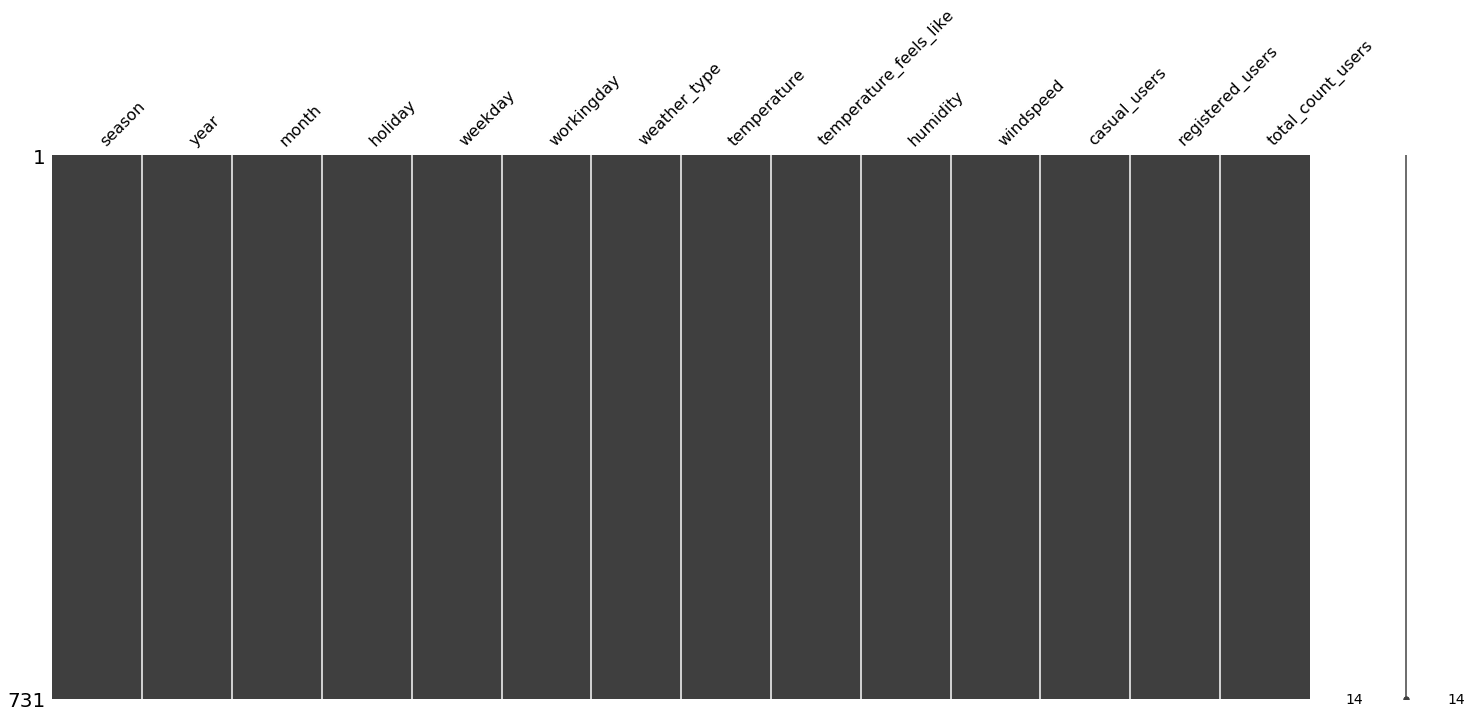

In [11]:
msno.matrix(data_day)

We can observe from the above analysis that our data has no null values

## Univariate Analysis 

### Categorical Features - Univariate Plots

In [12]:
# Starting with the standard imports
import numpy as np                                           # numerical libraries
import pandas as pd                                          # data-frames library


# Now the Graphical libraries imports and settings
import matplotlib.pyplot as plt                              # for plotting
import seaborn as sns                                        # nicer looking plots
#%matplotlib inline

plt.rcParams[ 'figure.figsize' ] = [30,15]
plt.rcParams[ 'legend.fontsize' ] = 20
plt.rcParams[ 'axes.labelsize' ] = 20
plt.style.use ('ggplot')  # emulate ggplot style

class CategoricalFeatureSummarizer :
    EPSILON = 1e-8
    '''
    Analyze a categorical feature, and generate the usual summary from it.
    '''
    def __init__(self, data, feature, name):
        self.data            = data
        self.feature         = feature
        self.name            = name

    #----------------------------------------------------------------
    def plot_frequency(self, log=False, width=30, height=20):
        '''
        Make a frequency plot of the feature
        '''
        ax = sns.countplot(x     = self.feature, 
                           data  = self.data,
                           order = self.data[self.feature].value_counts().index);
        plt.rcParams[ 'figure.figsize' ] = width,height
            
        ax.set_title(r' {} Frequency Distribution'.format(self.name));
        ax.set_xlabel(r' {}'.format(self.name));
        ax.set_ylabel('Frequency');
        plt.xticks(rotation=90);
        
        if log:
            ax.set_yscale('log')
            ax.set_title(r' {} $Logarithmic$ Frequency Distribution'
                         .format(self.name))
        plt.show()
    #----------------------------------------------------------------    
    def print_topN (self, topN=20, log=False):
        '''
        Print the top-N most frequent values for this feature
        '''
        if (log):
            tn = np.log(self.data[self.feature].value_counts())[0:topN]
        else:
            tn = self.data[self.feature].value_counts()[0:topN]
            
        print(tn)


#---------------------------------------------------------------------------


def displayColumnTypes (data):
    columnMeta = pd.DataFrame(columns=['Feature', 'Datatype'])
    for column in data.columns: 
        columnMeta = columnMeta.append({'Feature':column, 
                                        'Datatype': data[column].dtype}, 
                                       ignore_index=True)
    return columnMeta

#### Season Summary

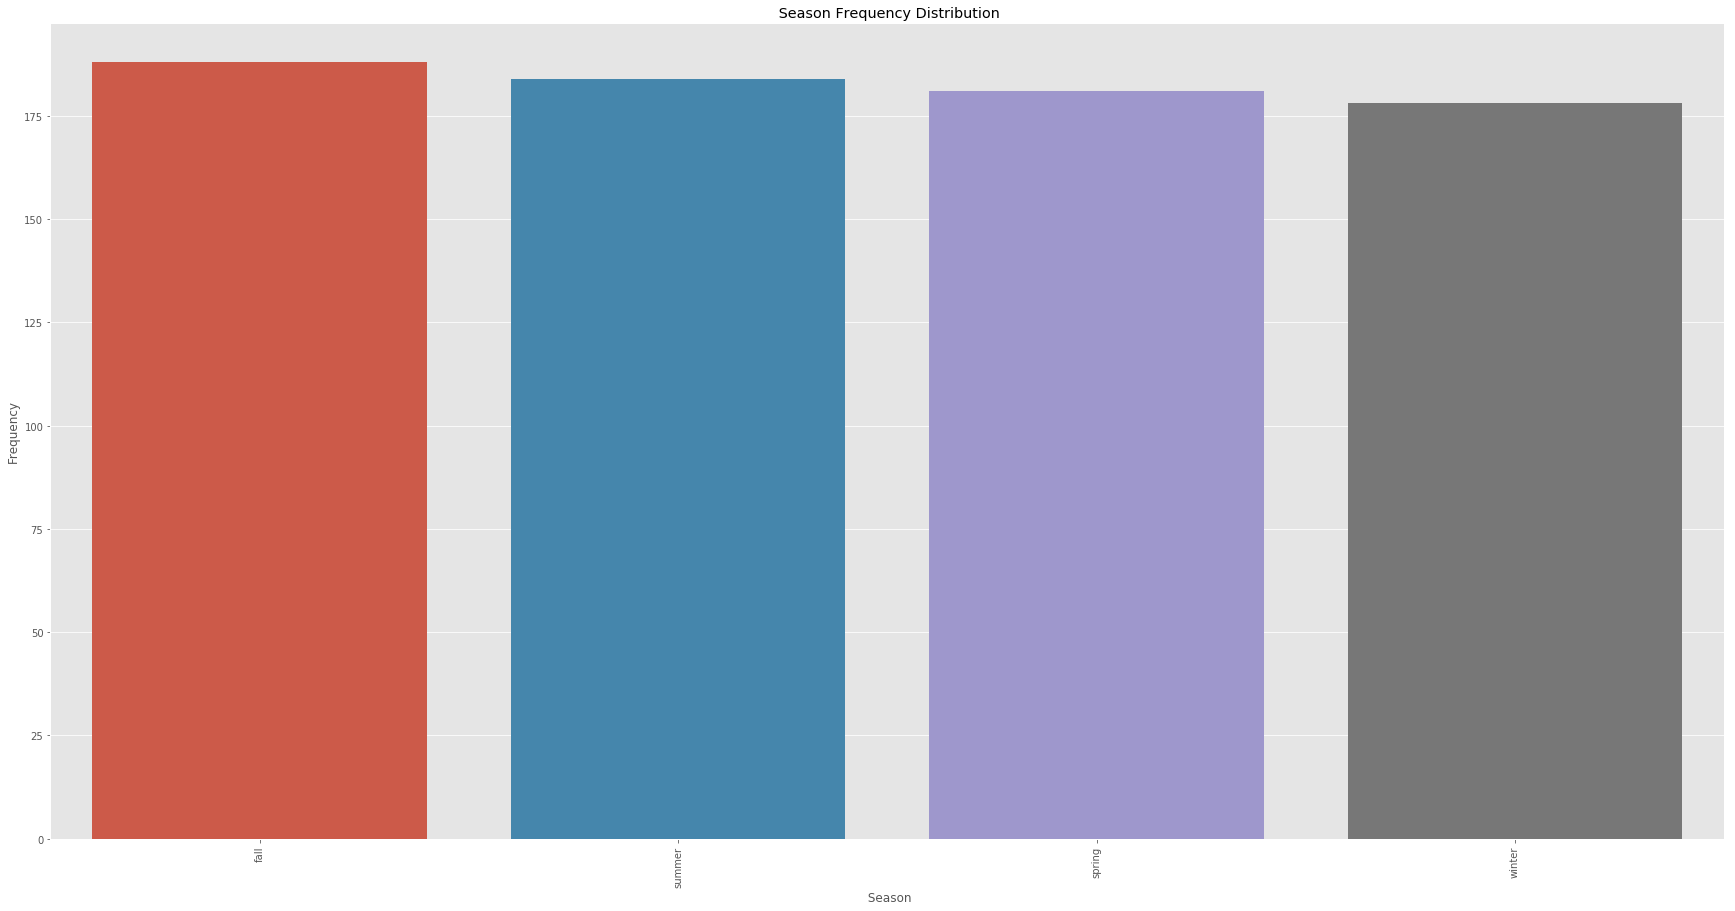

In [13]:
summarizer = CategoricalFeatureSummarizer(data_day, "season", "Season")
summarizer.plot_frequency()

#### Year Summary

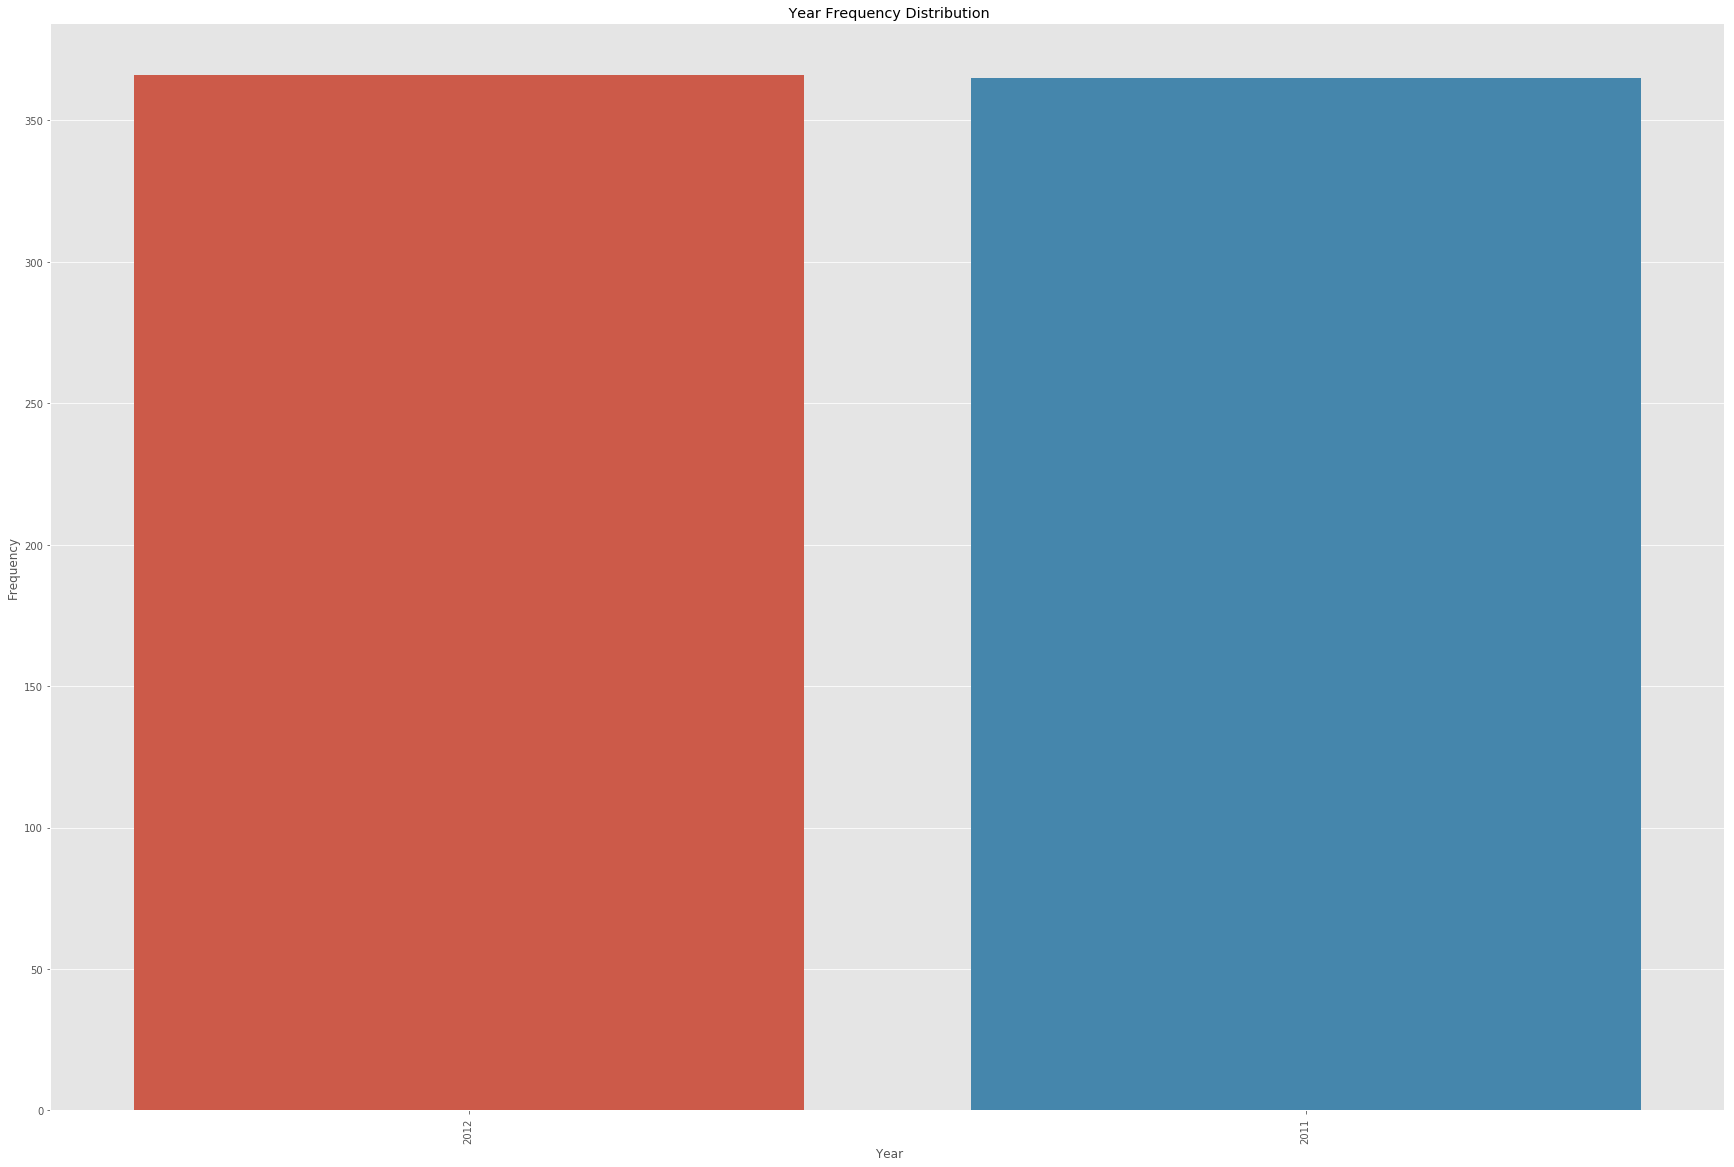

In [14]:
summarizer = CategoricalFeatureSummarizer(data_day, "year", "Year")
summarizer.plot_frequency()

#### Month Summary 

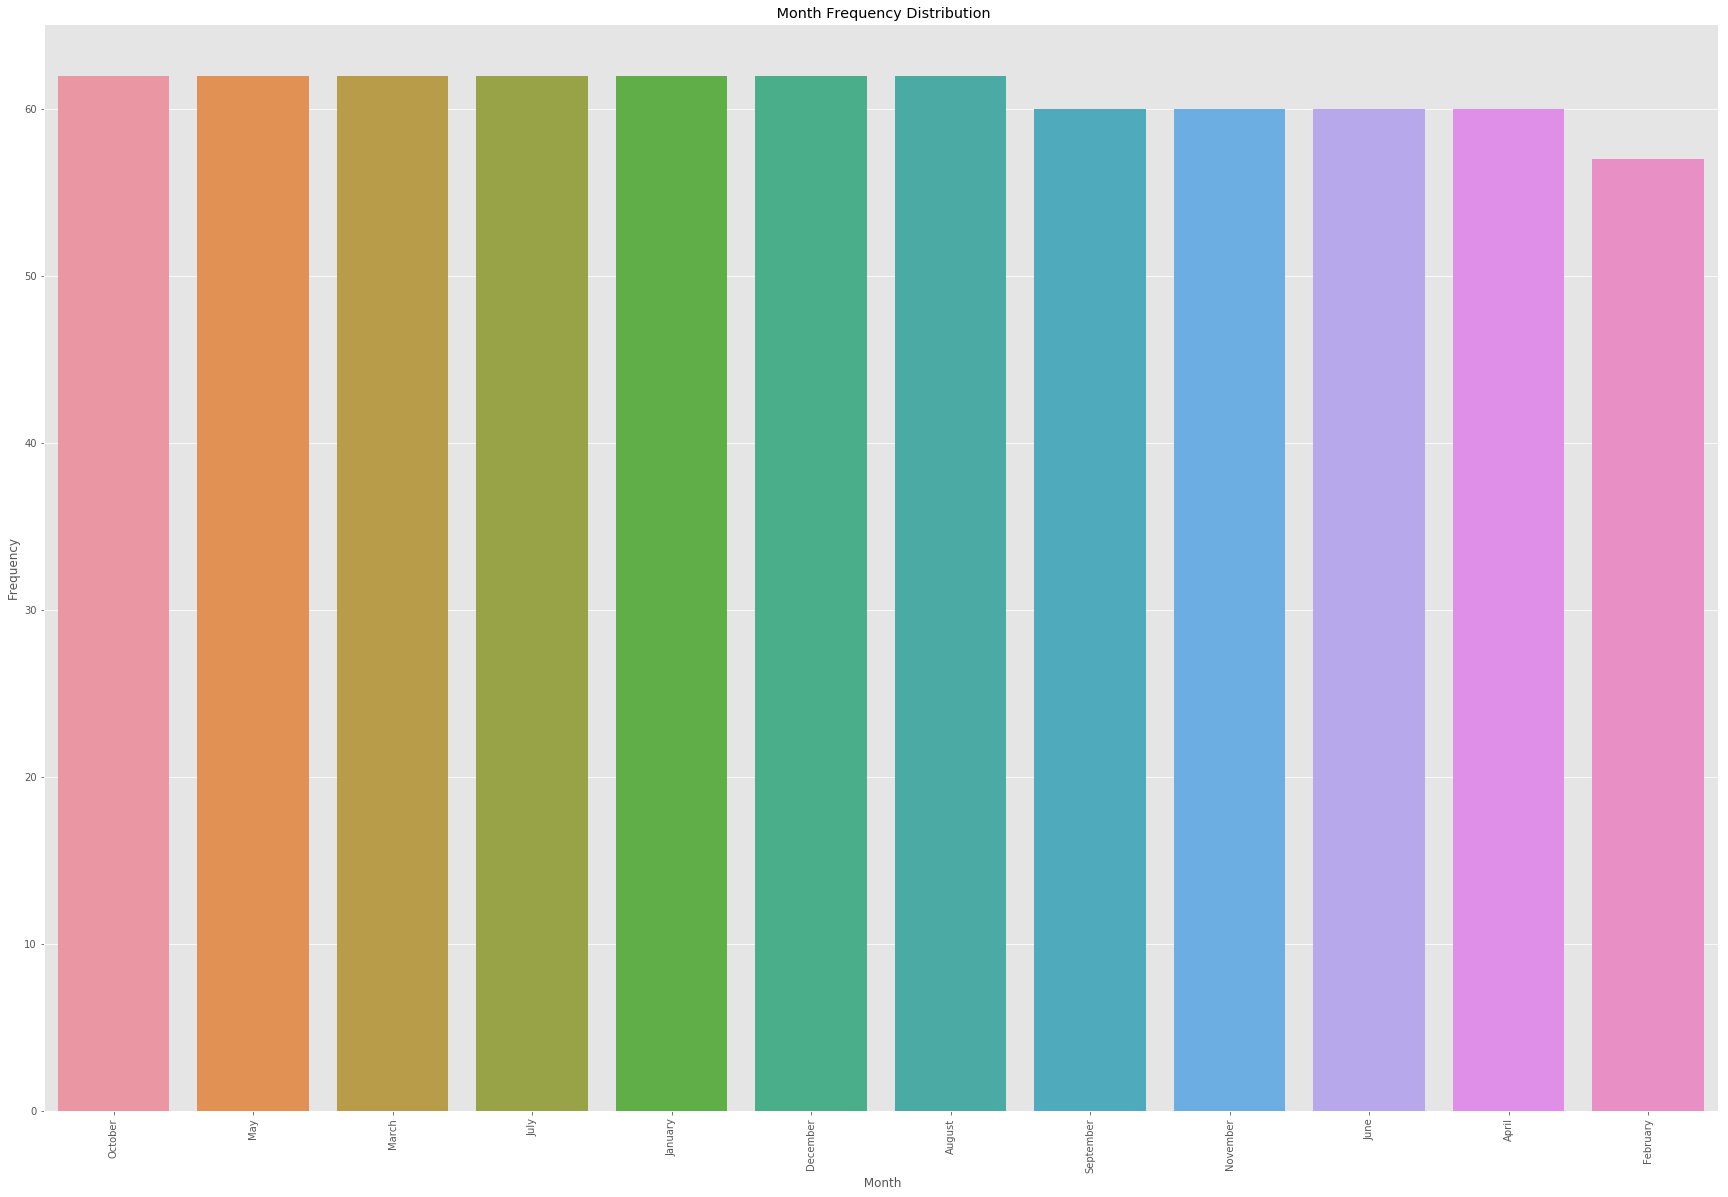

In [15]:
summarizer = CategoricalFeatureSummarizer(data_day, "month", "Month")
summarizer.plot_frequency()

#### Holiday Summary 

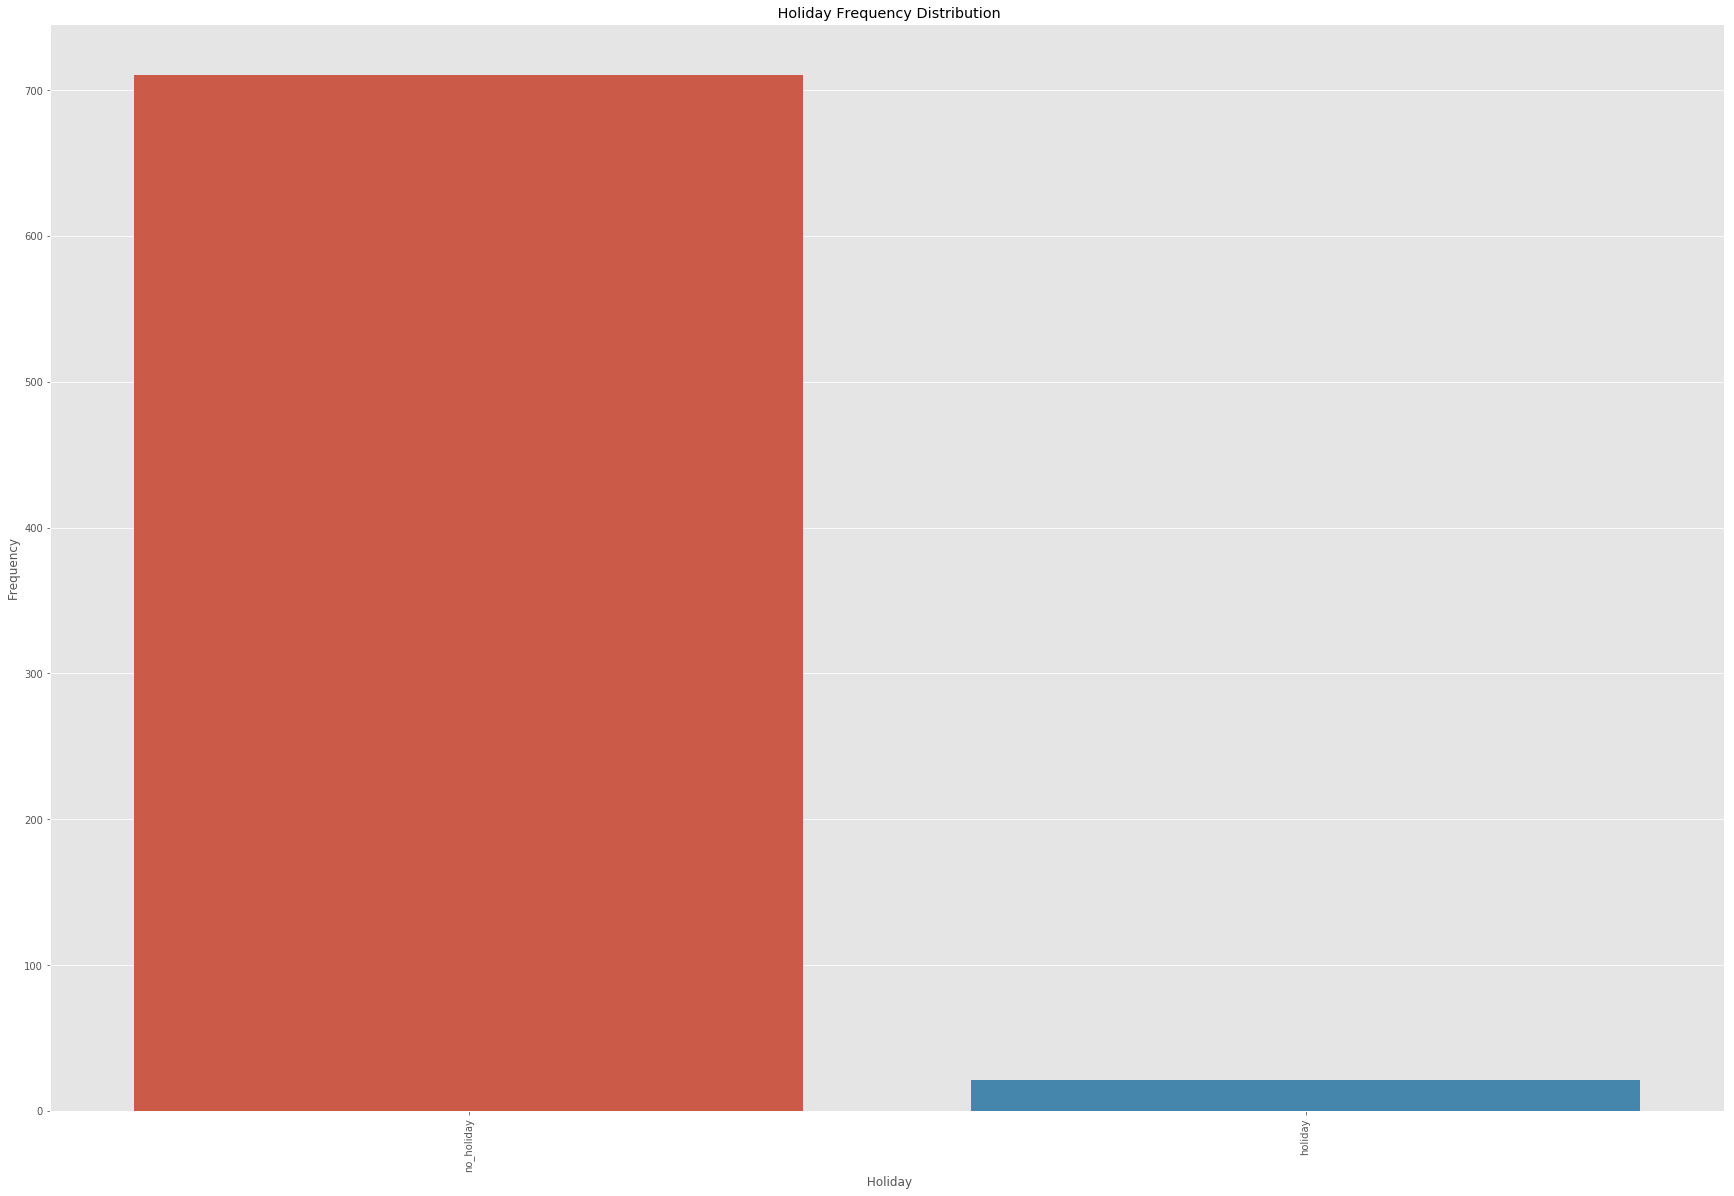

In [16]:
summarizer = CategoricalFeatureSummarizer(data_day, "holiday", "Holiday")
summarizer.plot_frequency()

#### Week-day Summary

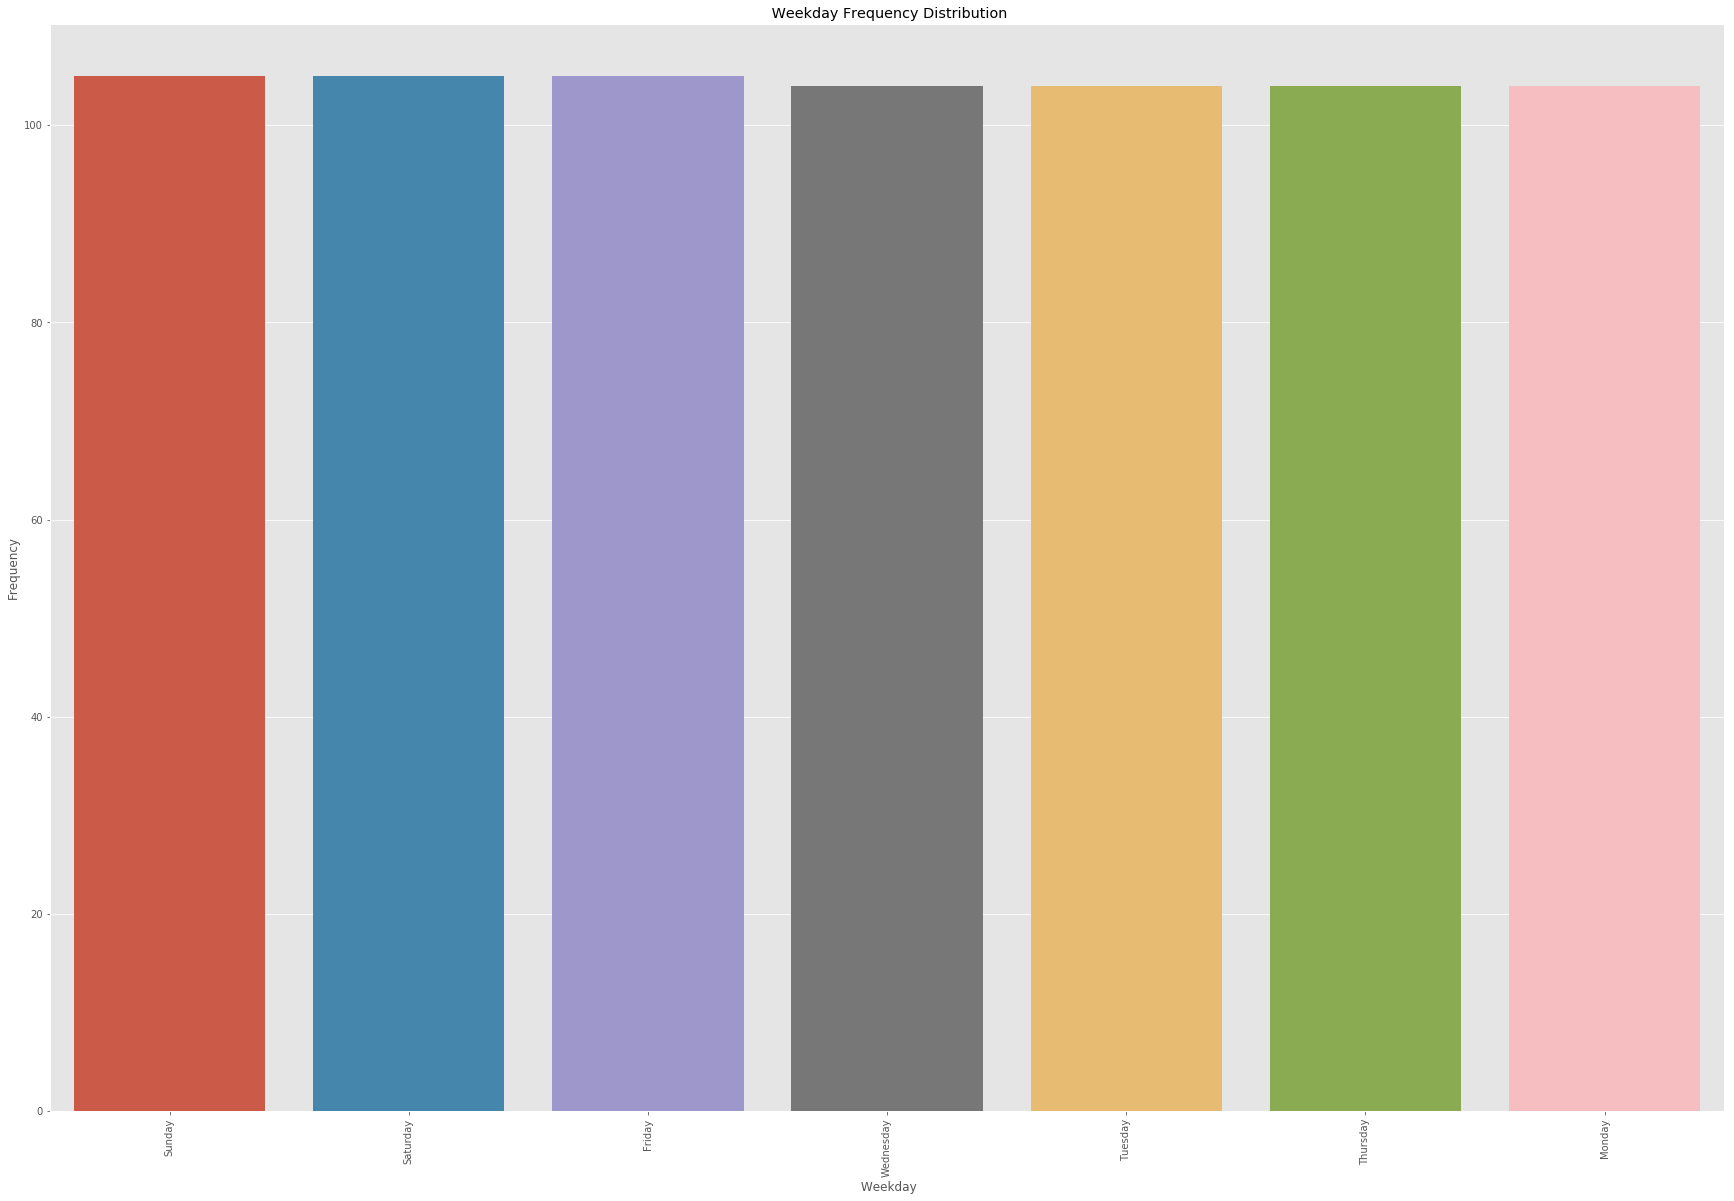

In [17]:
summarizer = CategoricalFeatureSummarizer(data_day, "weekday", "Weekday")
summarizer.plot_frequency()

#### Working Day Summary

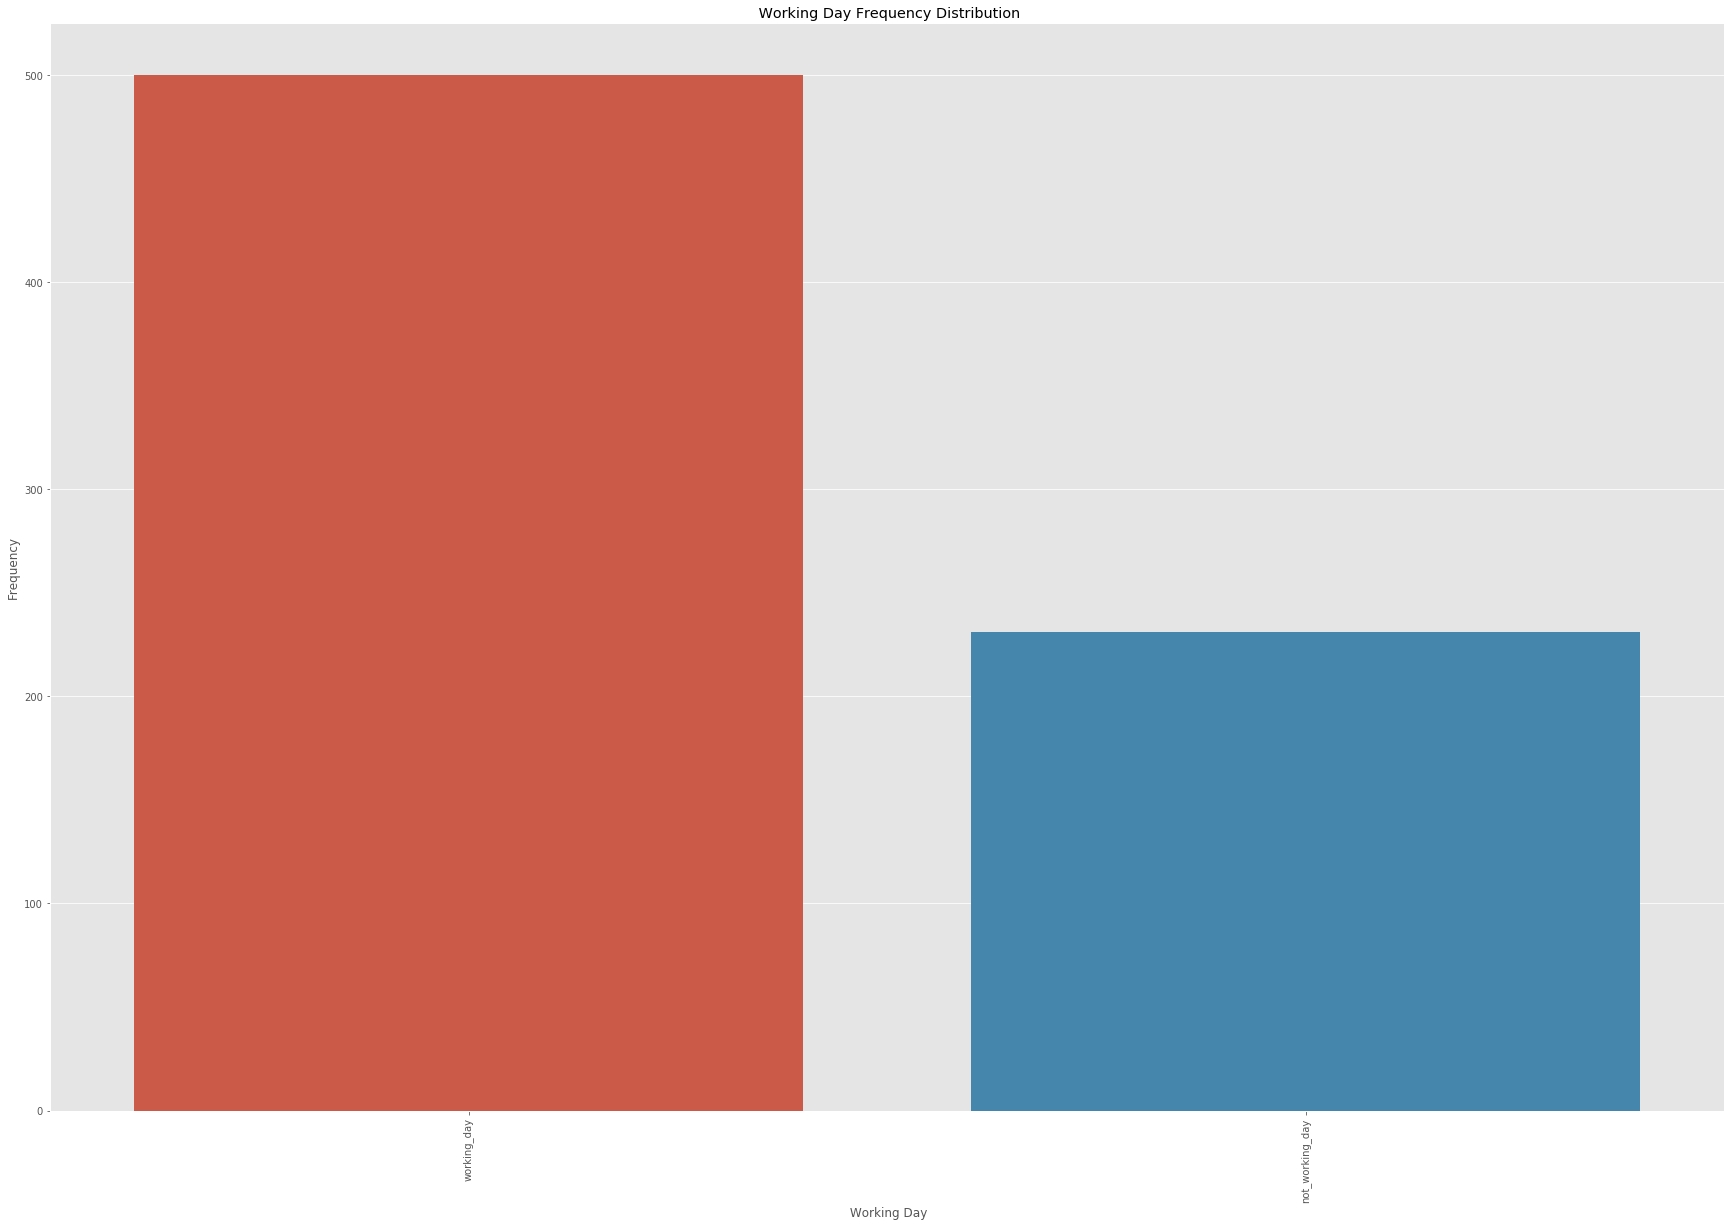

In [18]:
summarizer = CategoricalFeatureSummarizer(data_day, "workingday", "Working Day")
summarizer.plot_frequency()

#### Weather Type Summary

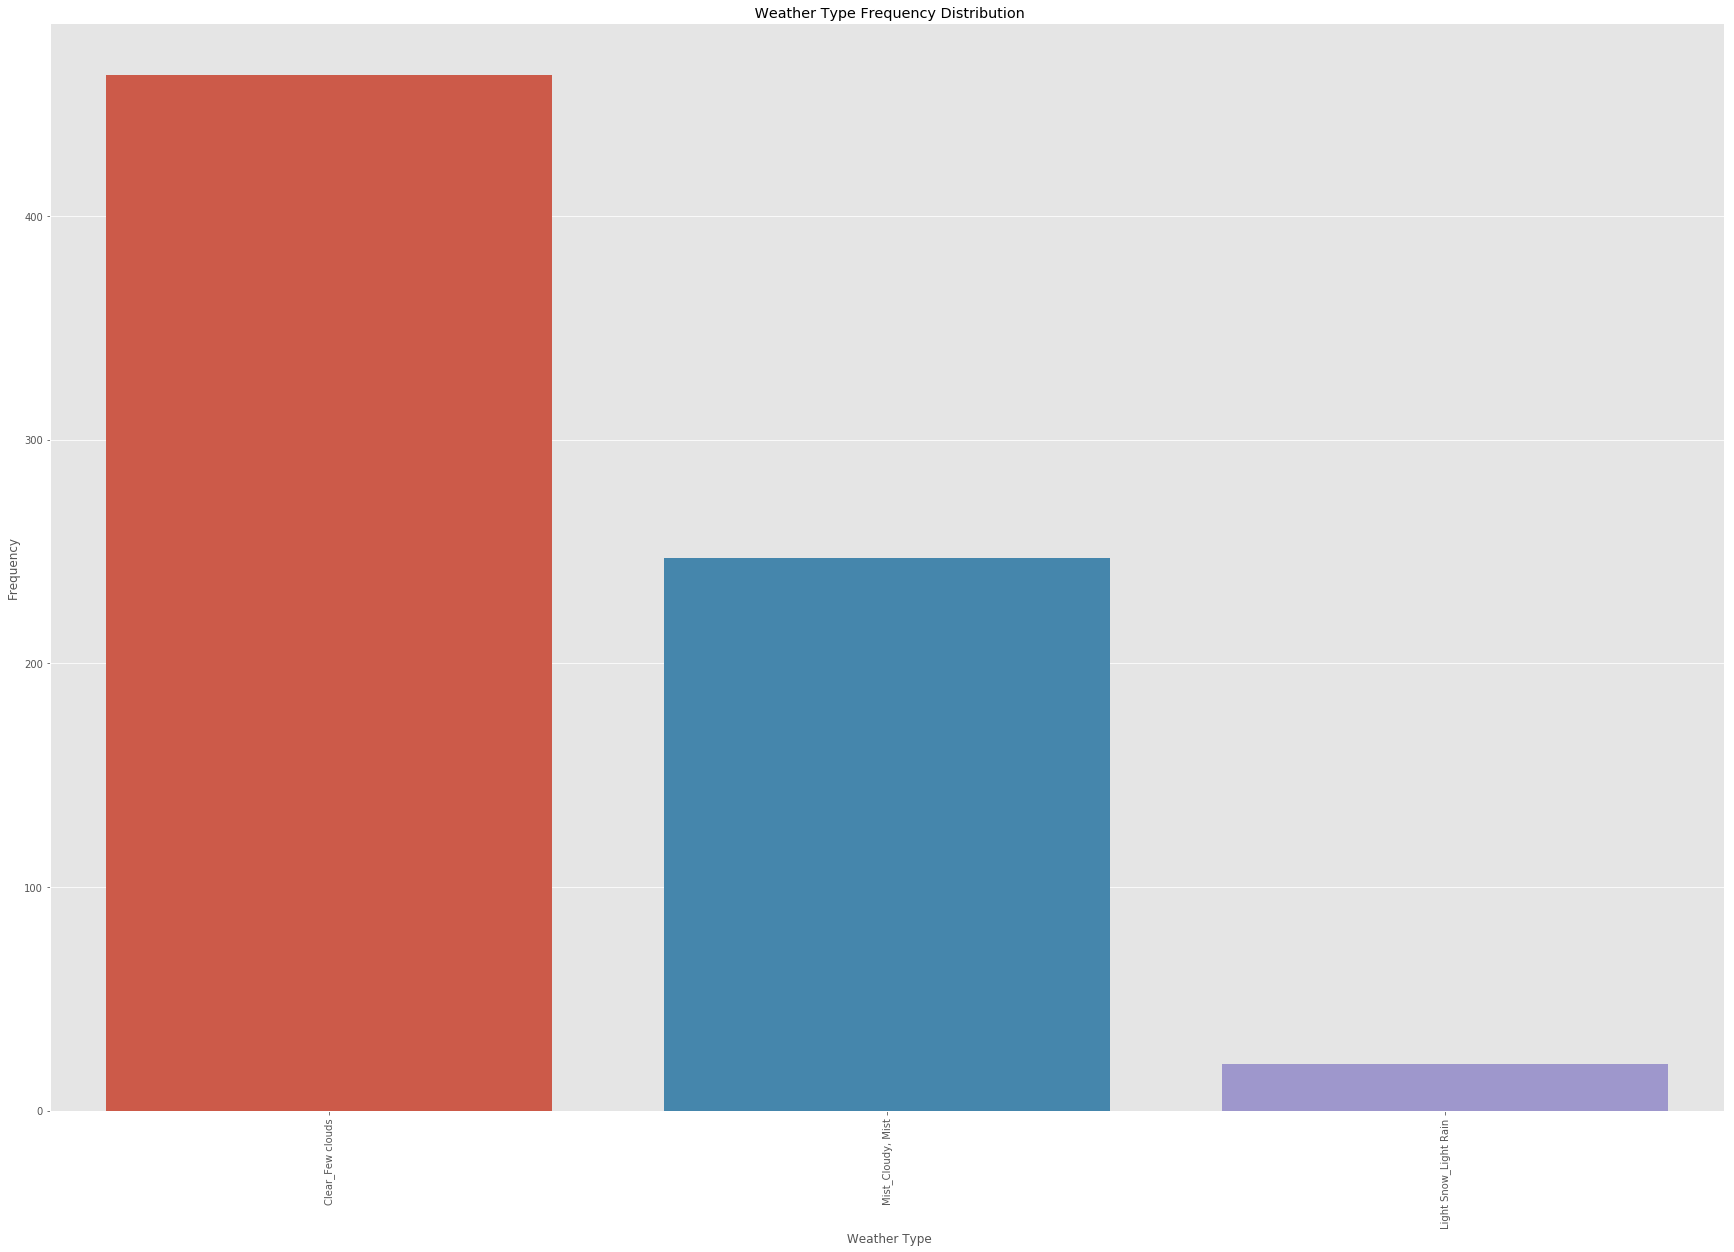

In [19]:
summarizer = CategoricalFeatureSummarizer(data_day, "weather_type", "Weather Type")
summarizer.plot_frequency()

### The $\mathbb{R}$-Valued Fields
Now, we make the histogram for each of the real-valued fields.

#### Distribution of Temperature

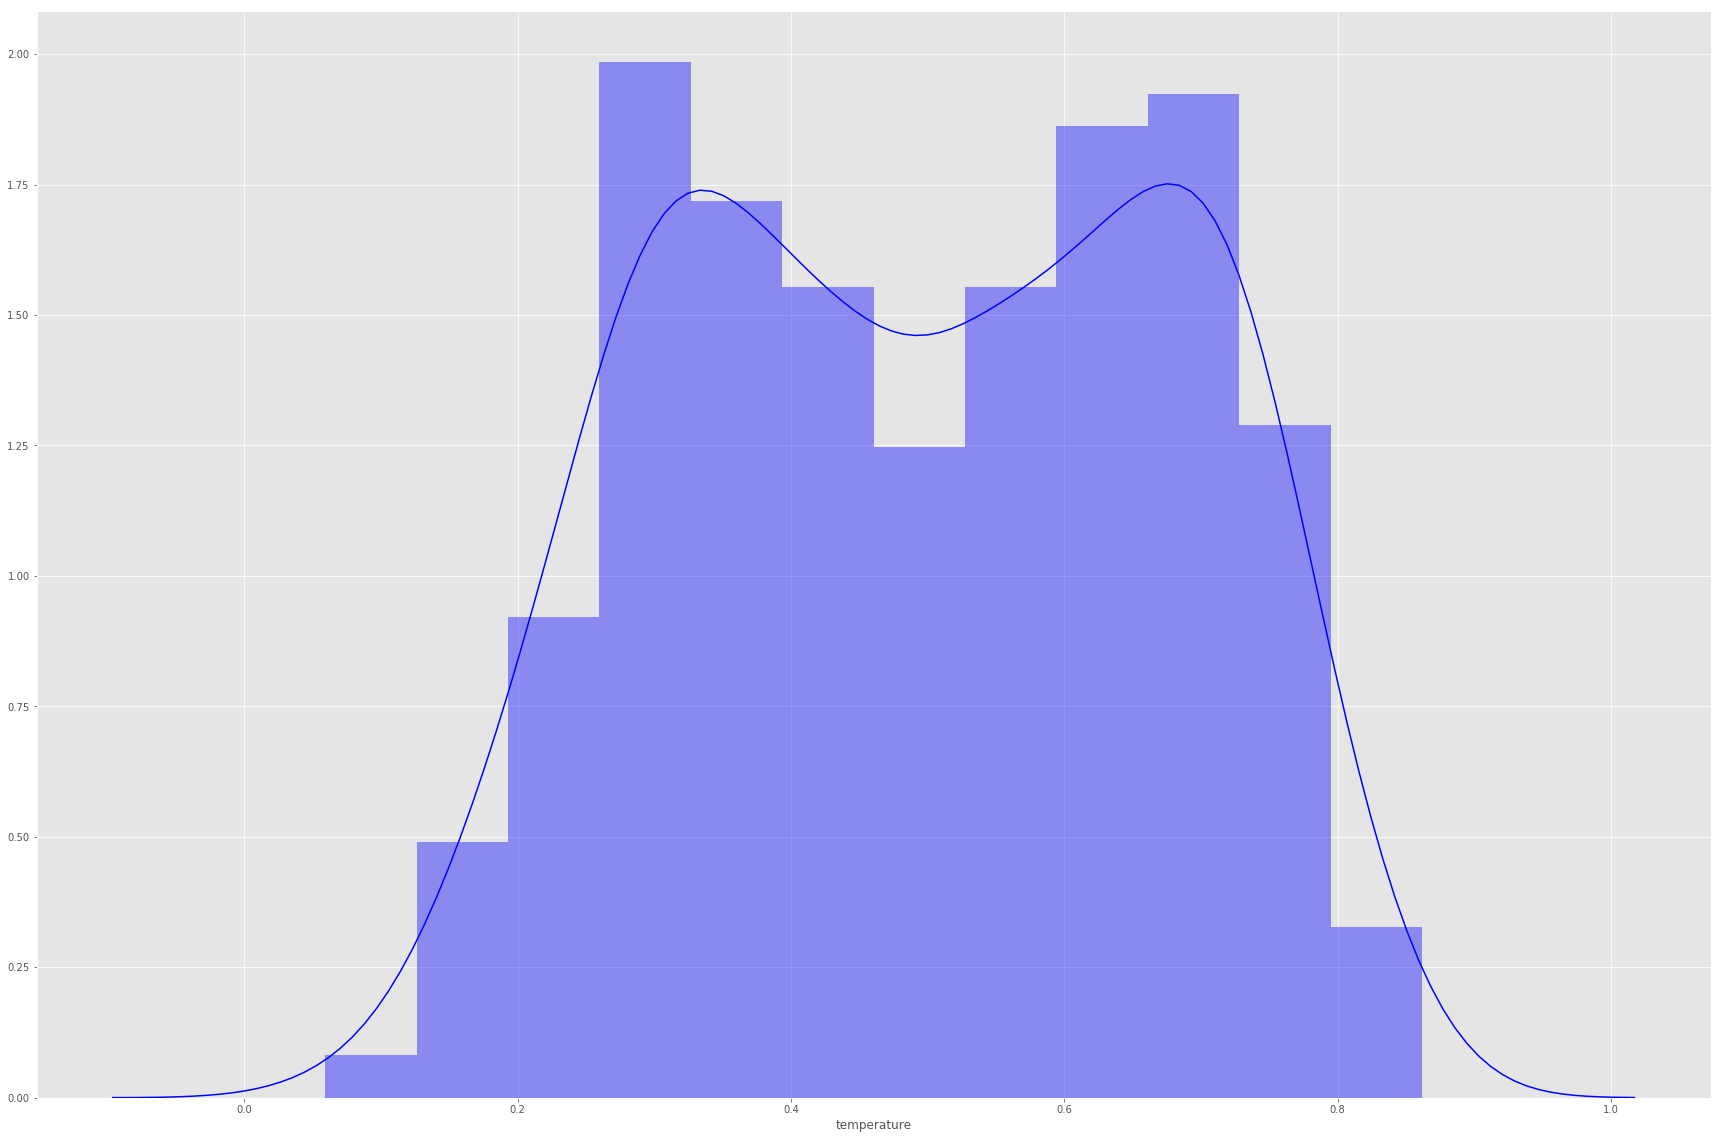

In [20]:
sns.distplot(data_day["temperature"], color="blue")

#### Distribution of Feels-Like Temperature

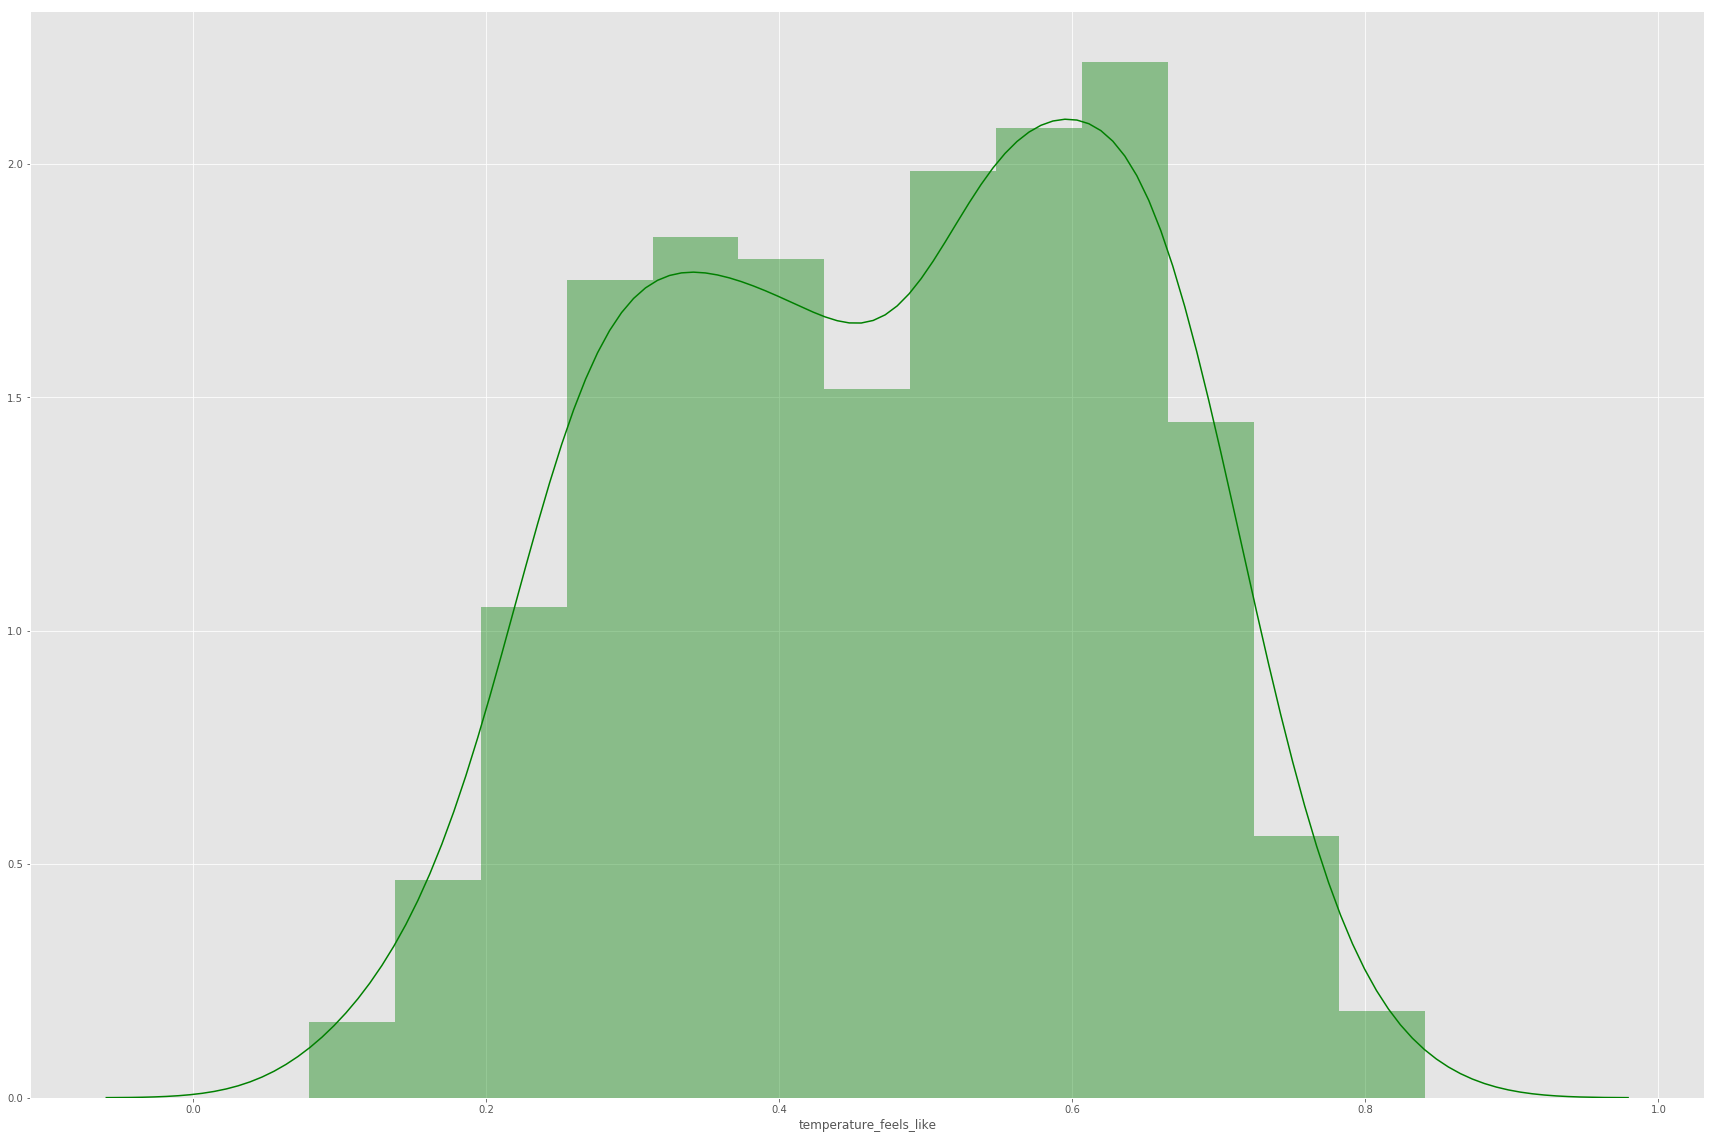

In [21]:
sns.distplot(data_day["temperature_feels_like"], color="green")

#### Distribution of Humidity

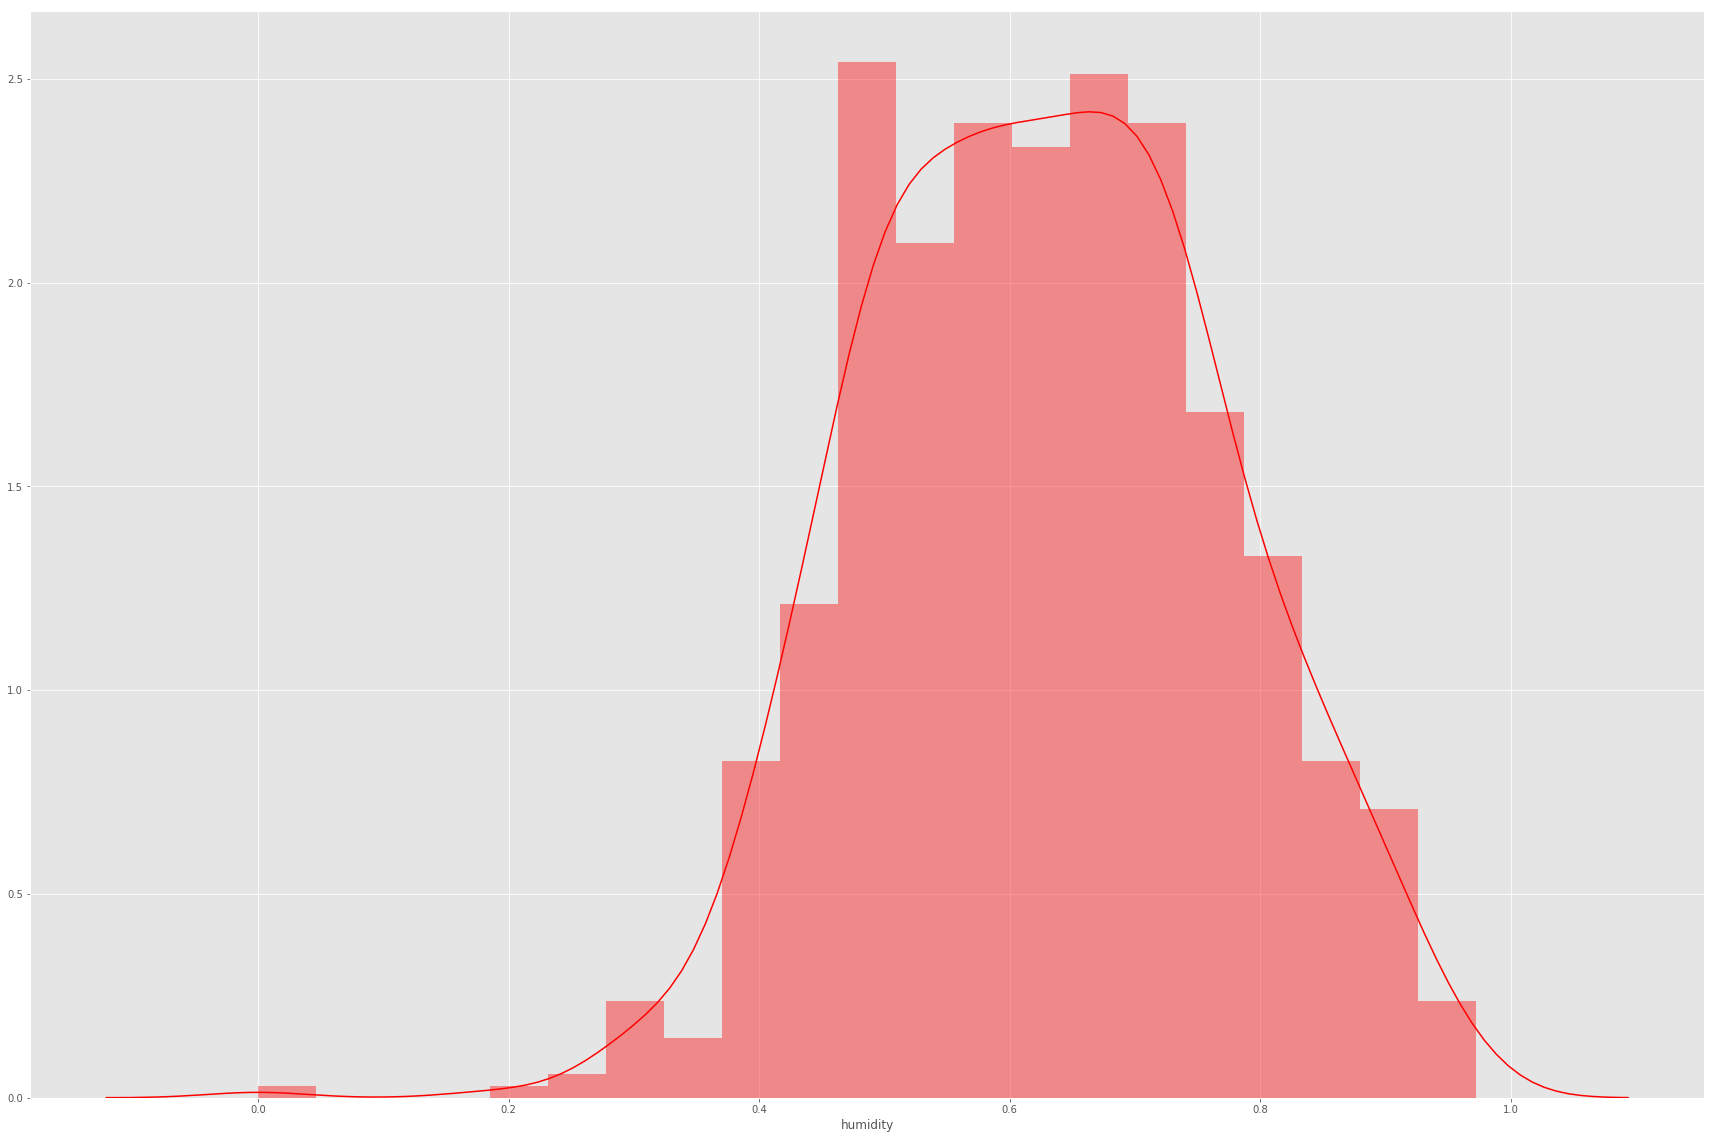

In [22]:
sns.distplot(data_day["humidity"], color="red")

#### Distribution of Wind-speed

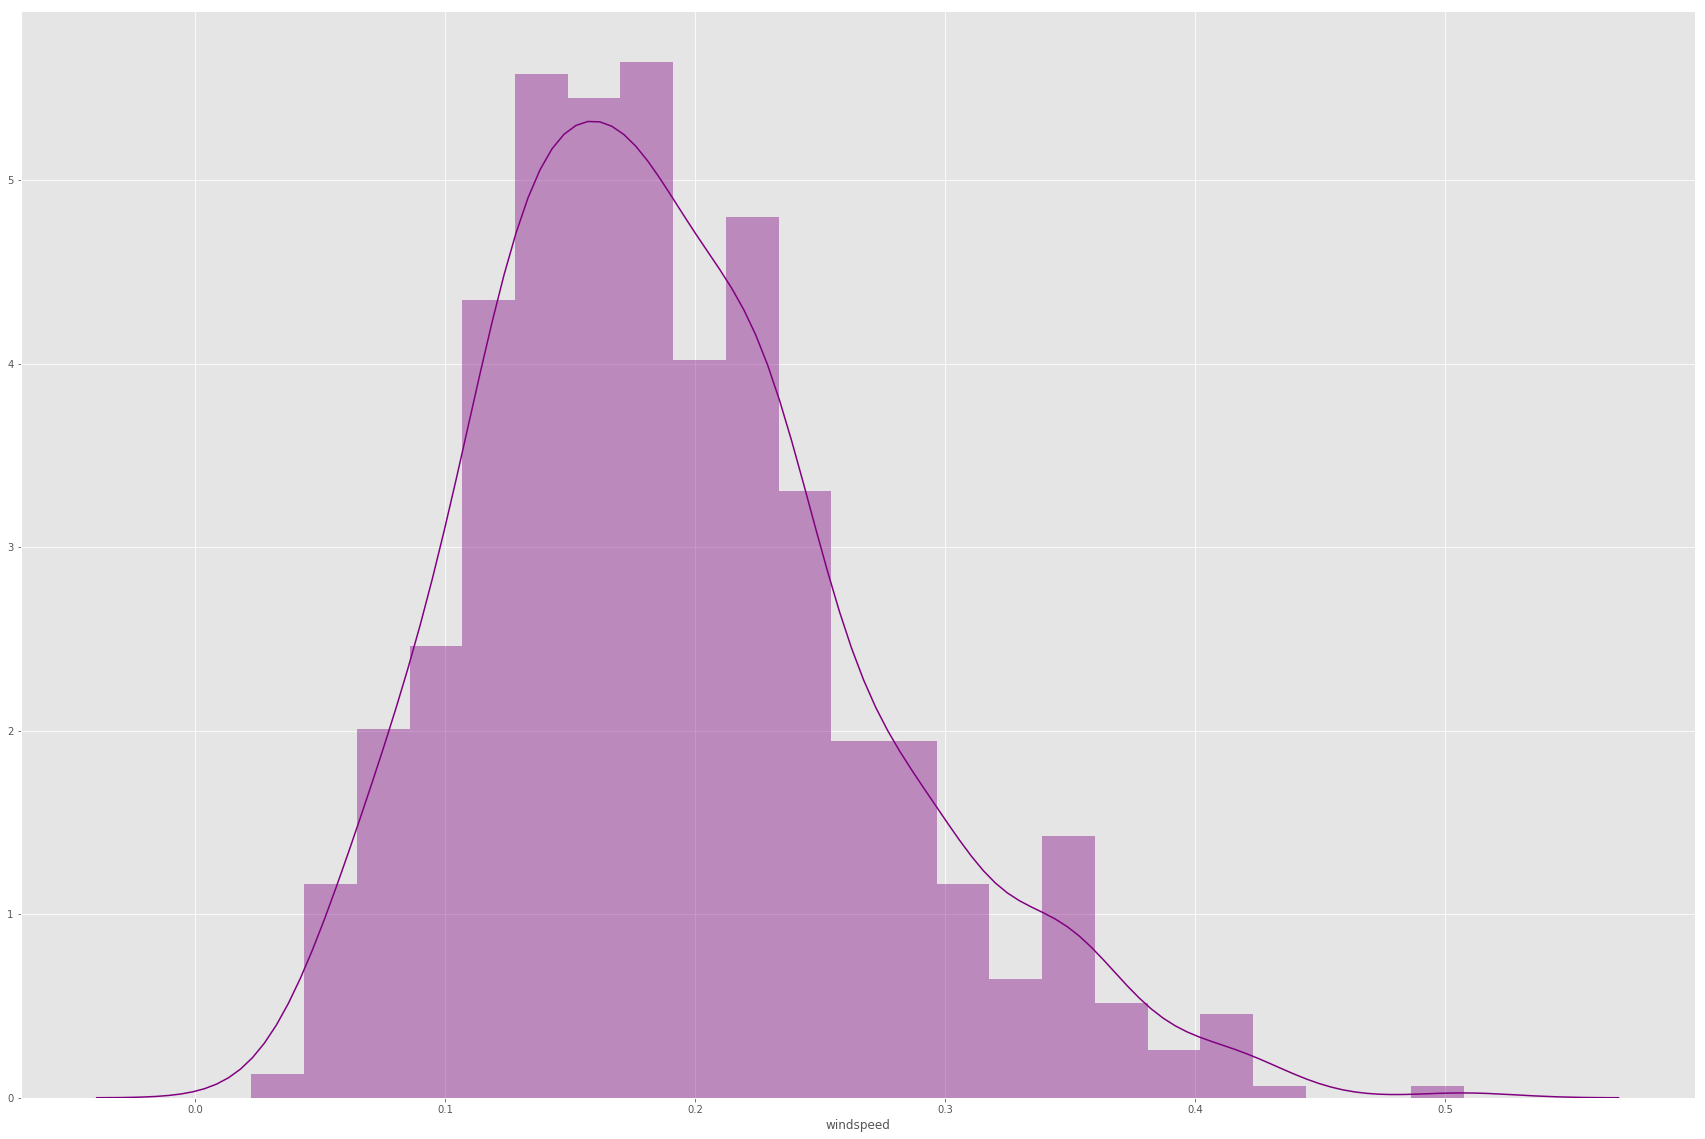

In [23]:
sns.distplot(data_day["windspeed"], color="purple")

#### Distribution of Casual Users

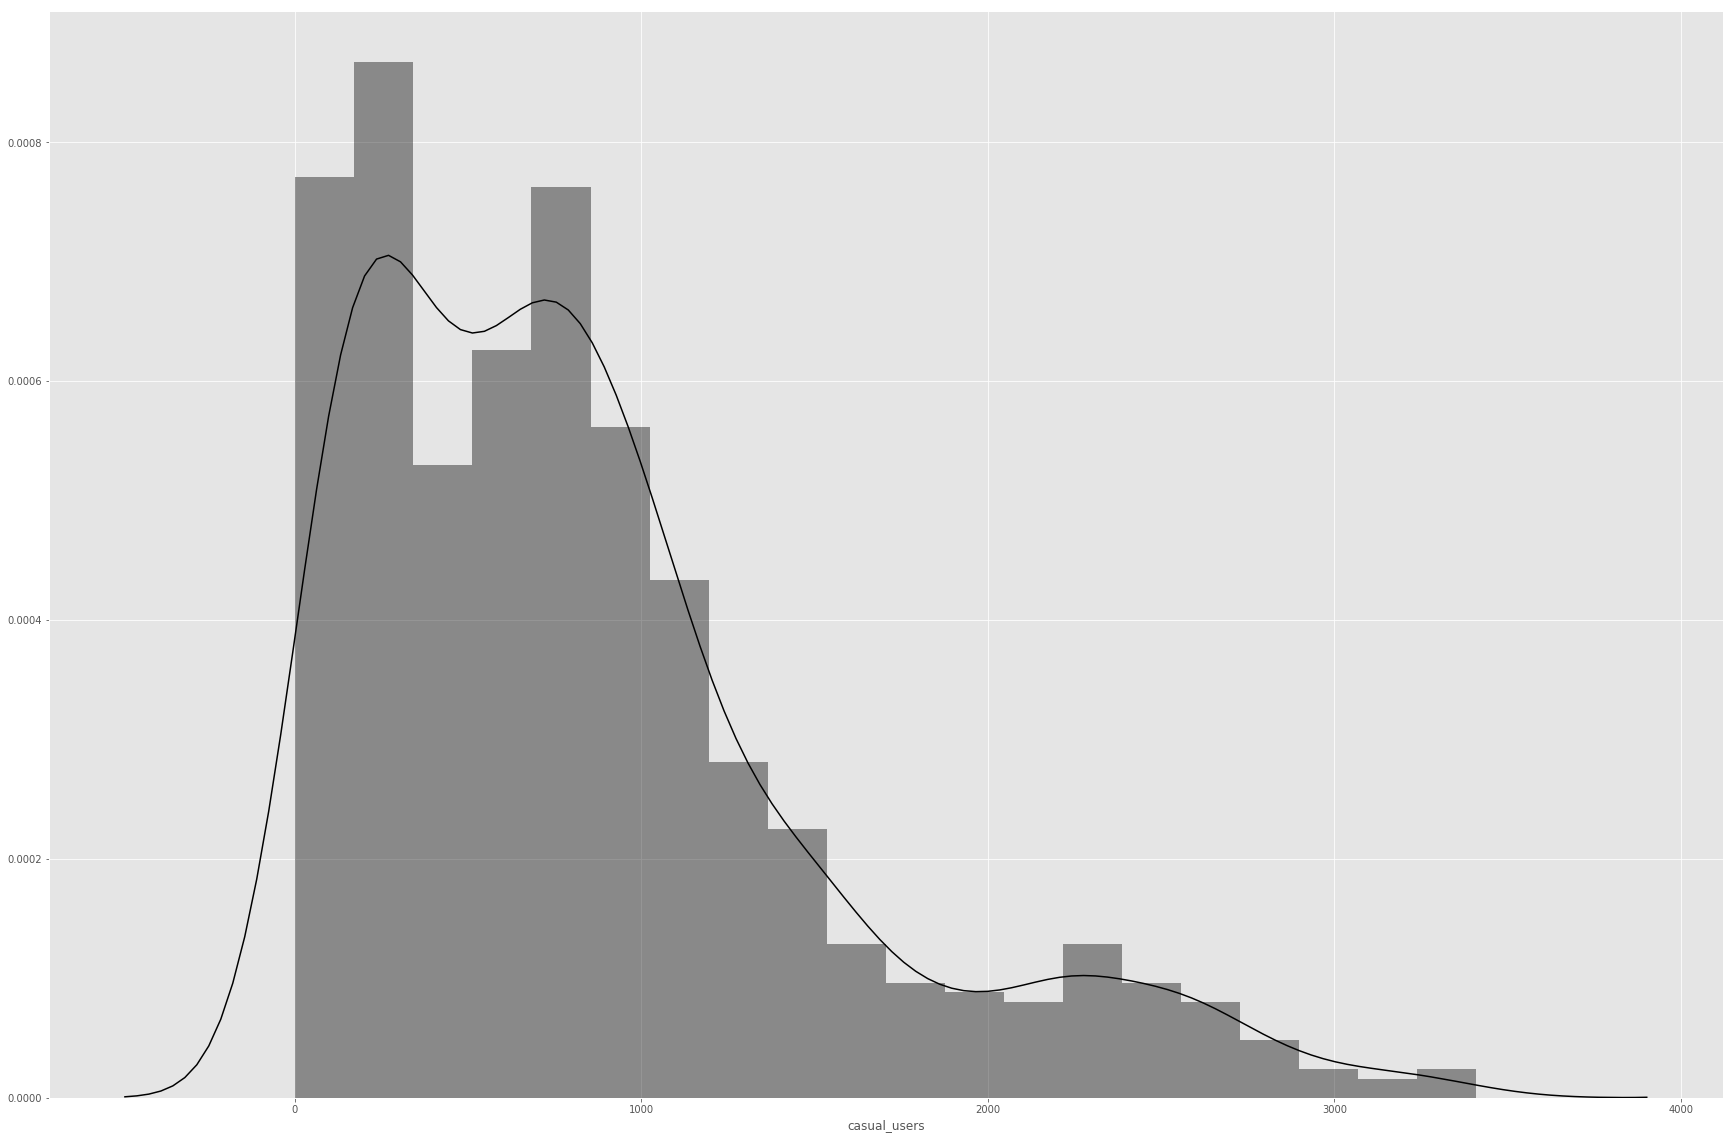

In [24]:
sns.distplot(data_day["casual_users"], color="black")

#### Distribution of Registered Users

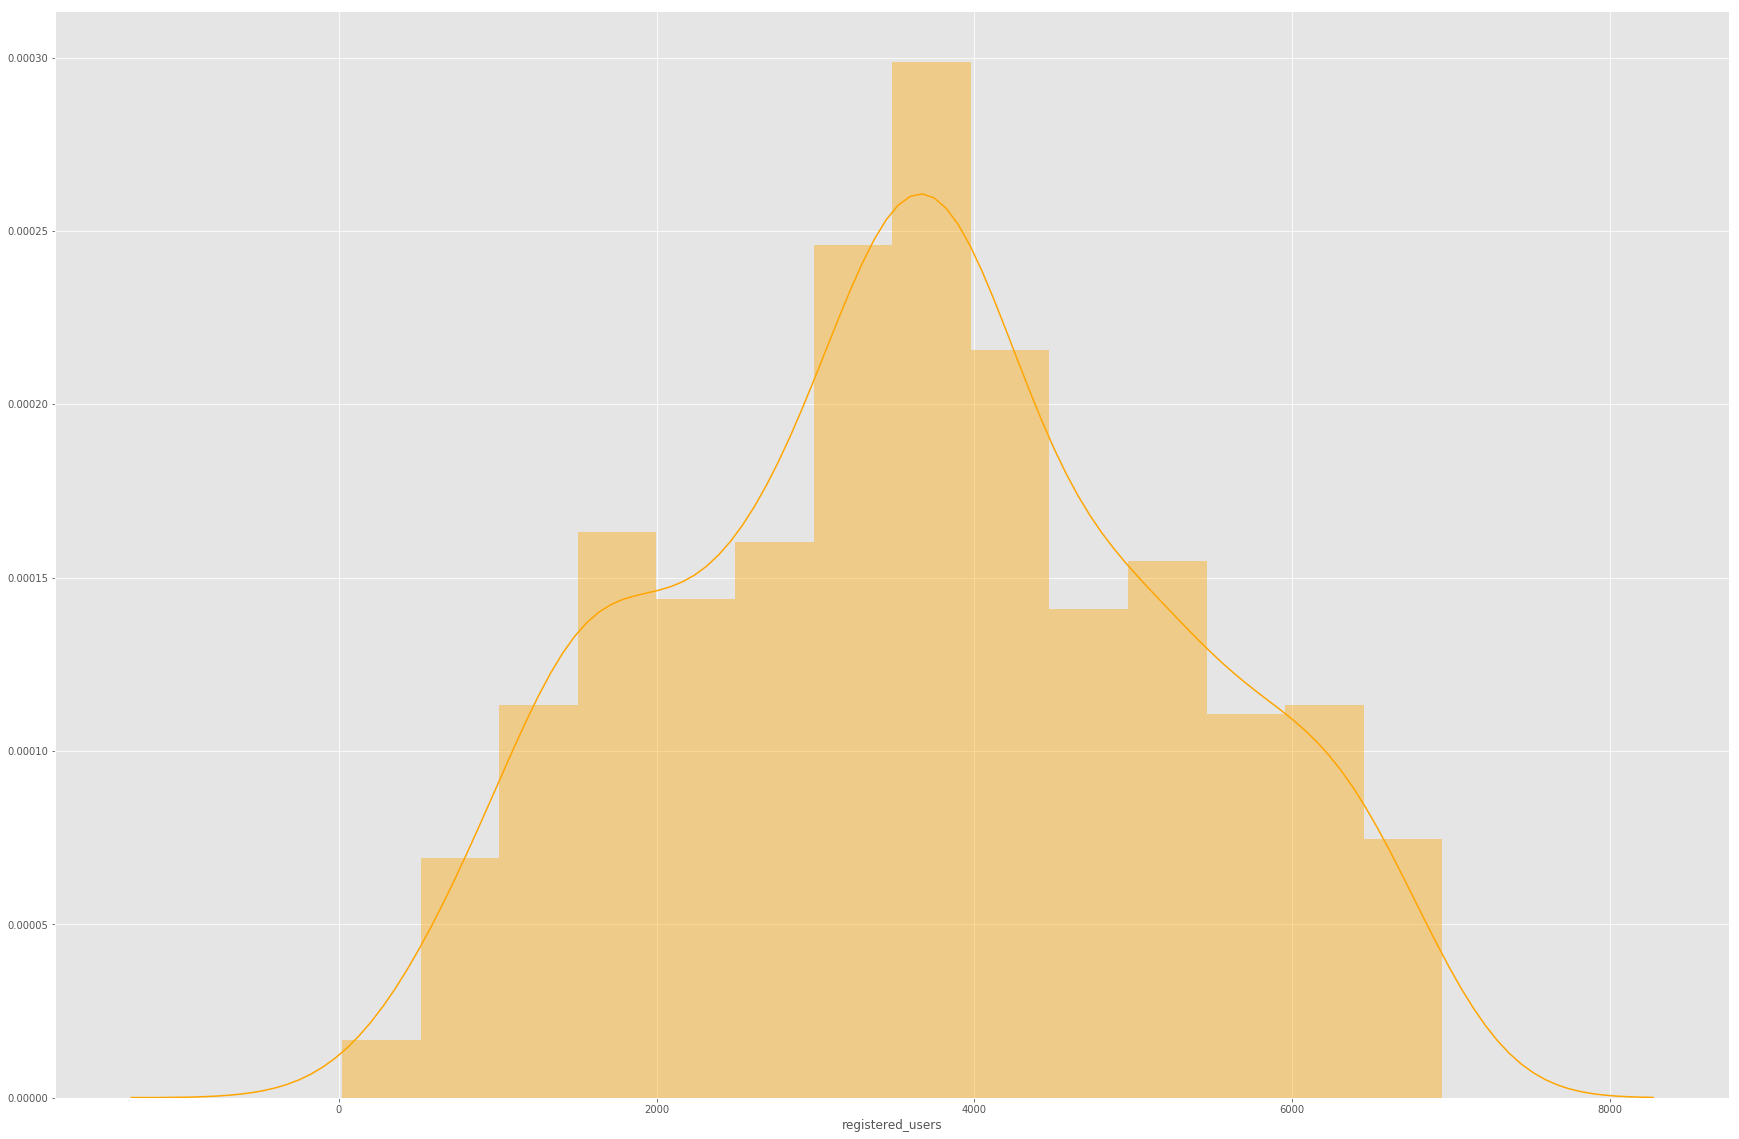

In [25]:
sns.distplot(data_day["registered_users"], color="orange")

#### Distribution of Total Users

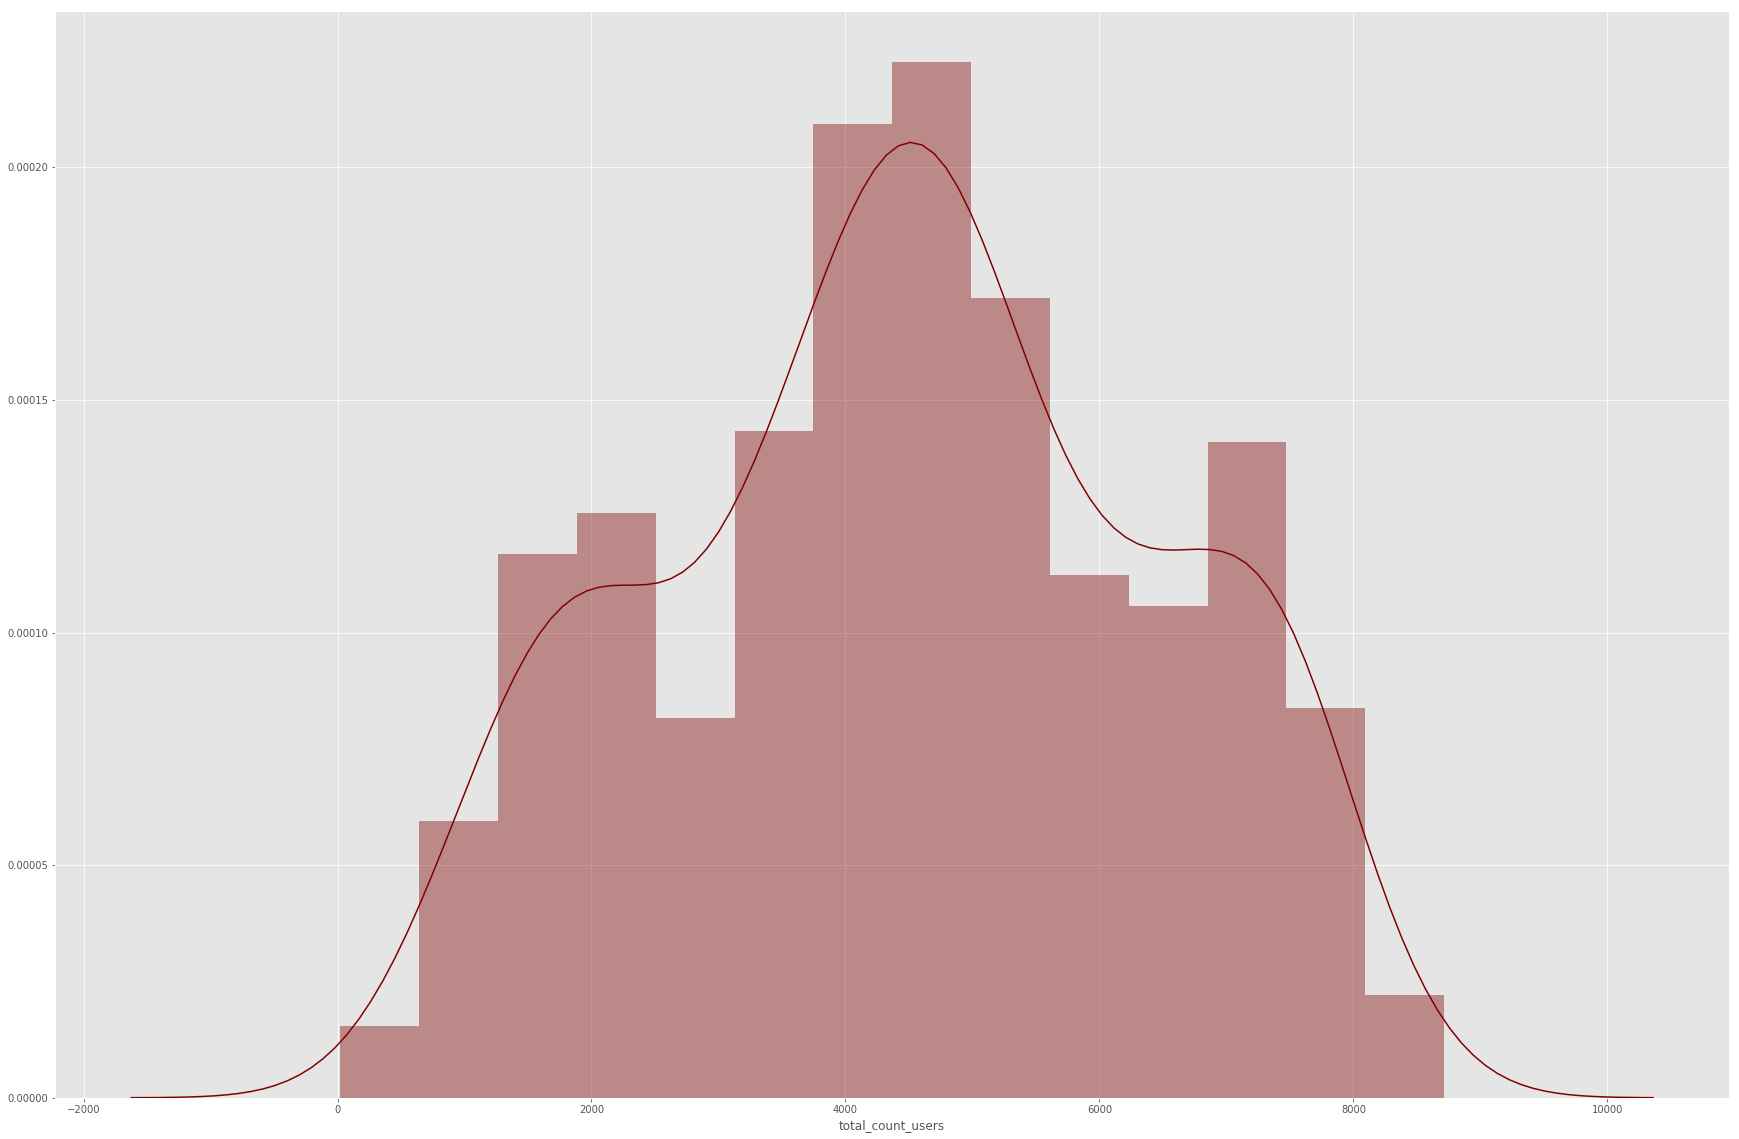

In [26]:
sns.distplot(data_day["total_count_users"], color="maroon")

## Bivariate Analysis 

### Pair Plot

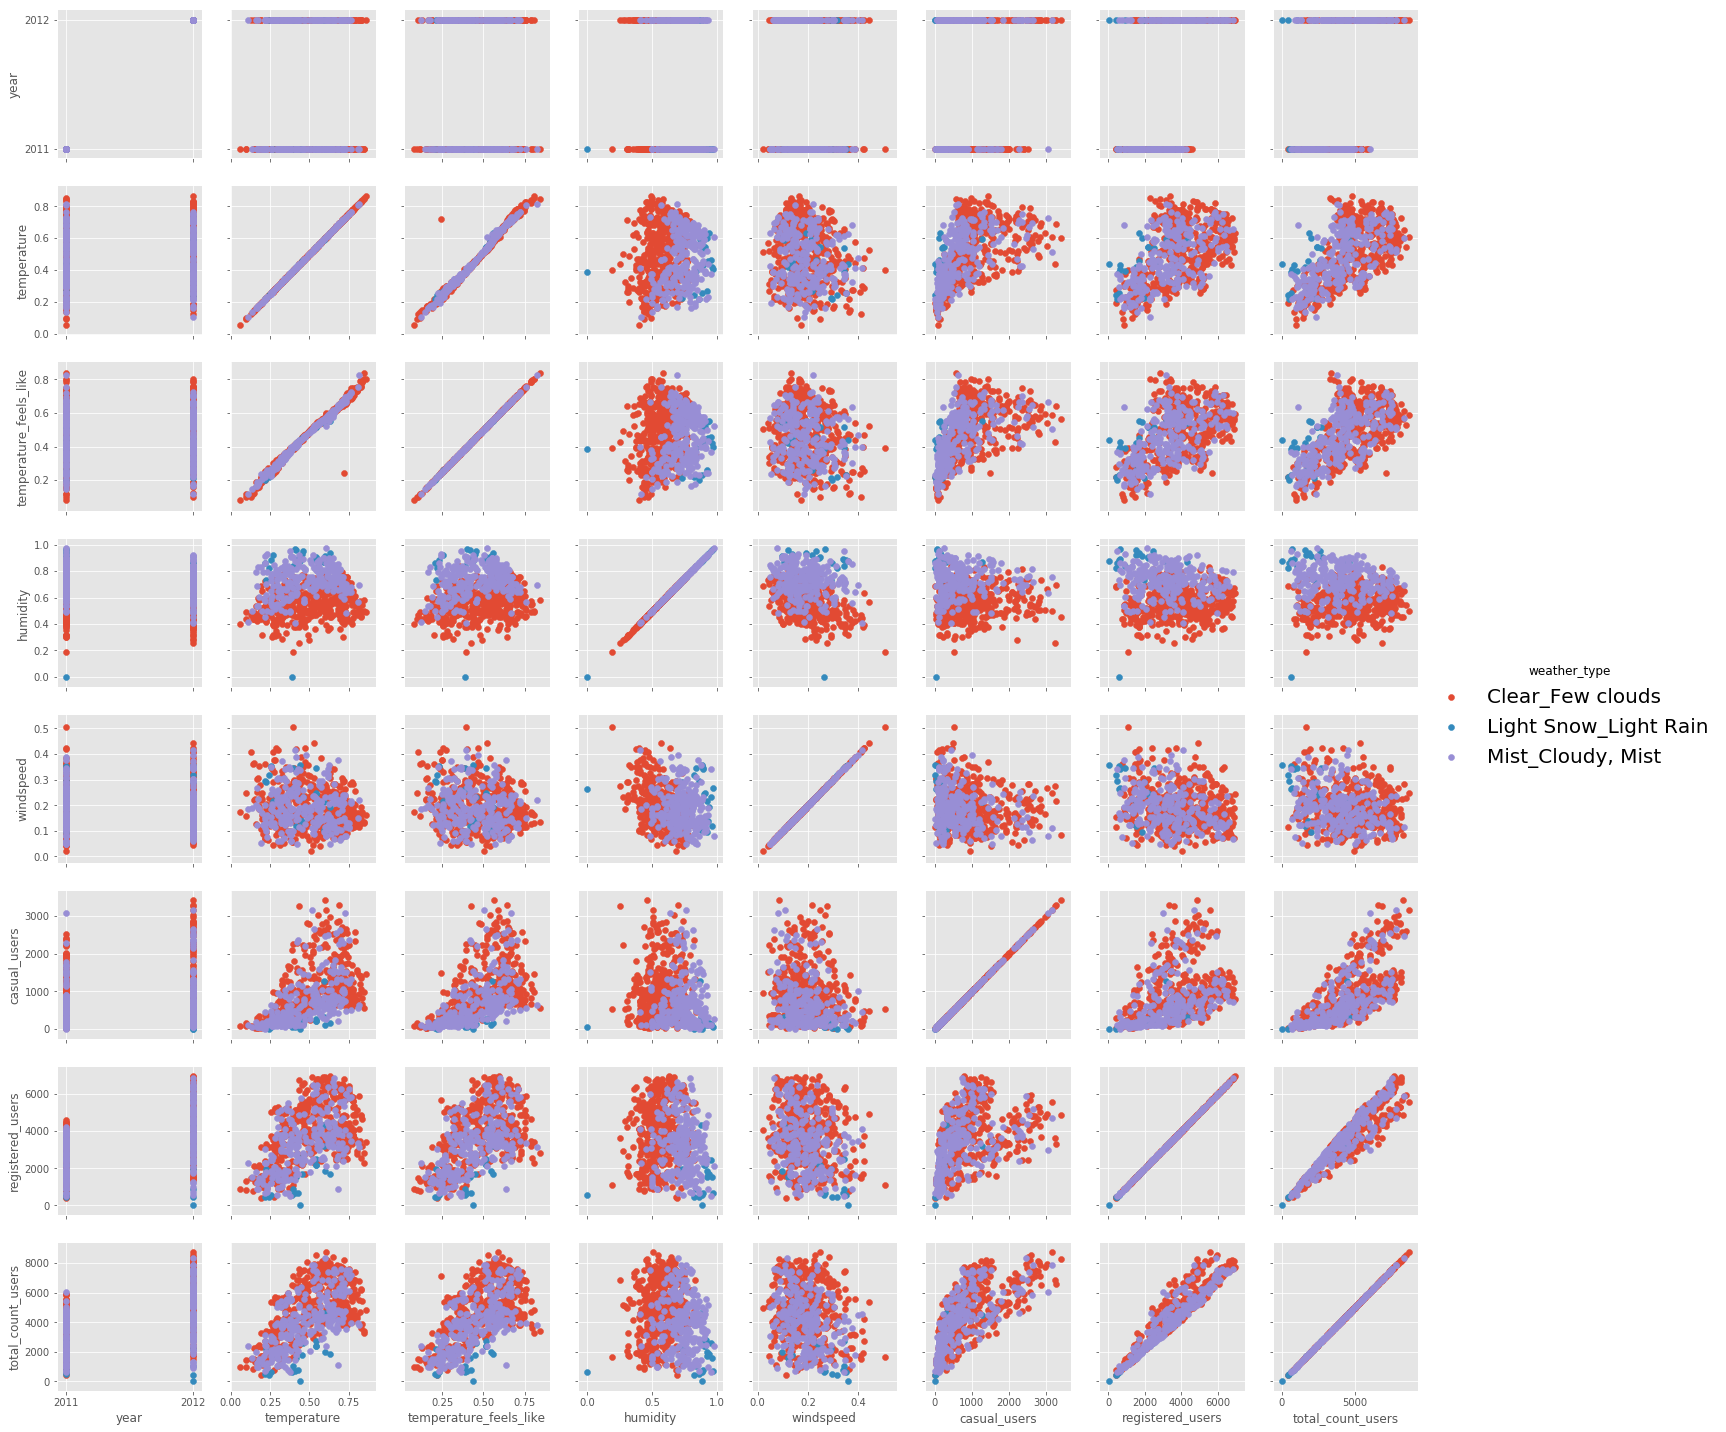

In [27]:
g = sns.PairGrid(data_day, hue = "weather_type")
g.map(plt.scatter)
g = g.add_legend()

### Correlation Plot

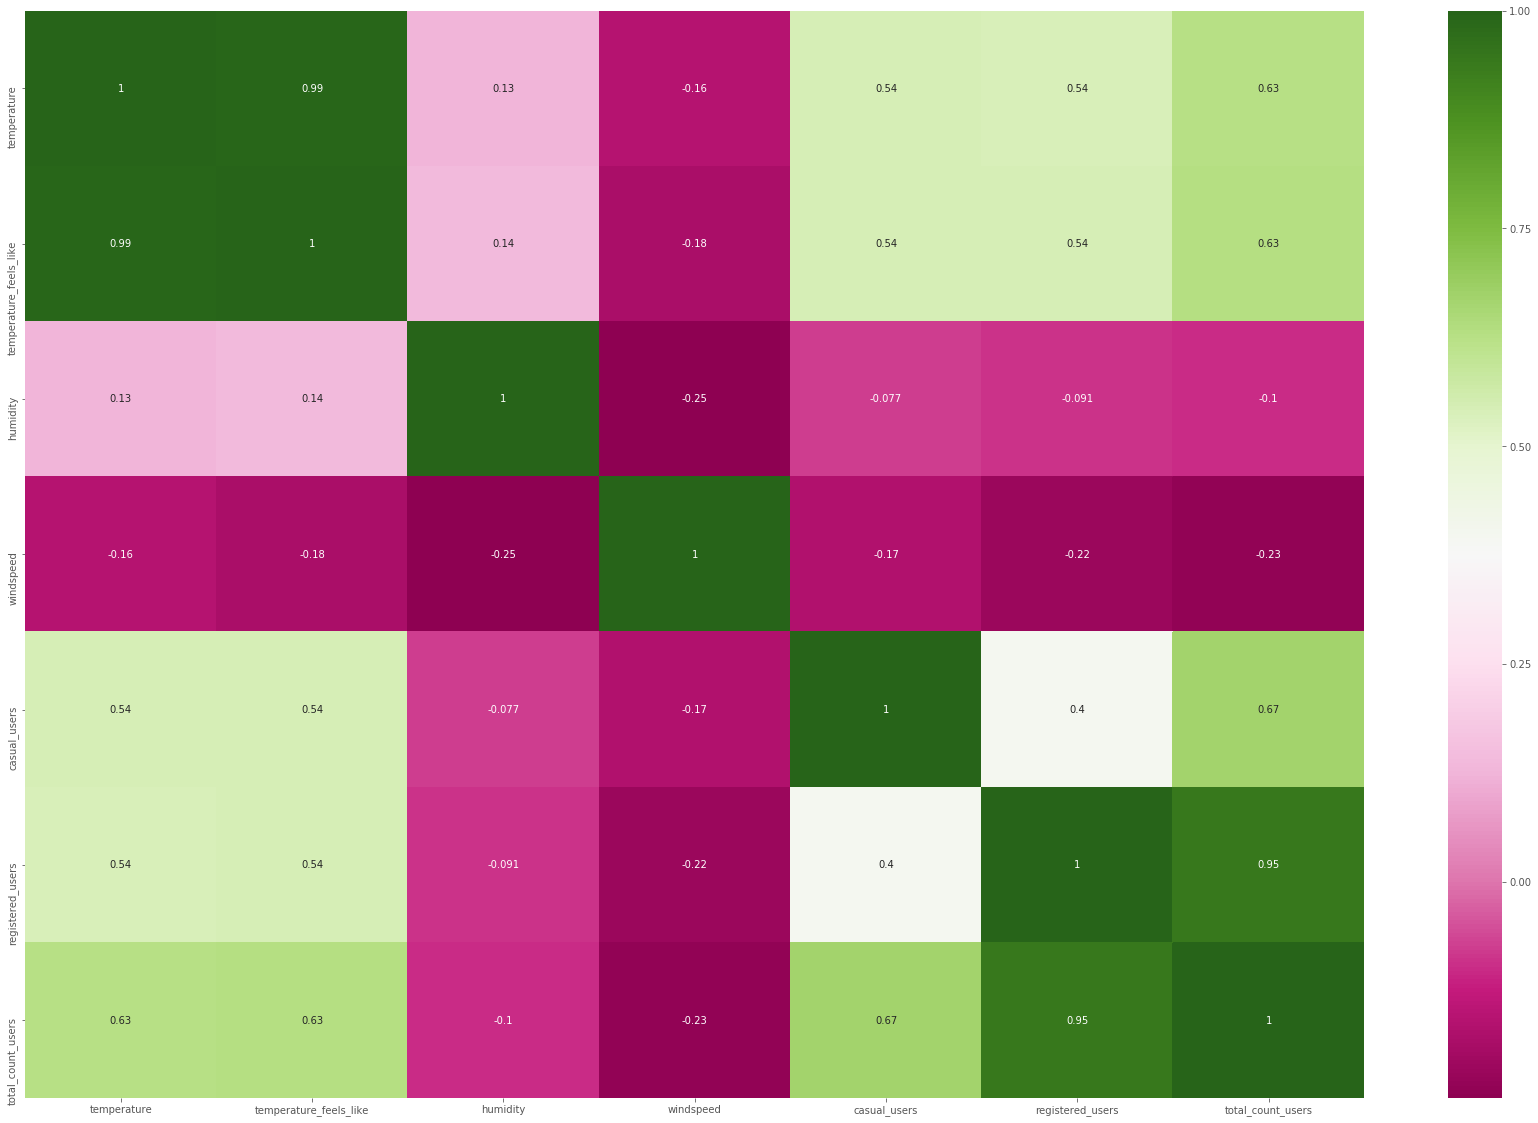

In [28]:
sns.heatmap(data_day.corr(), cmap="PiYG", annot=True)

From the above correlation plot, we can observe that temperature and feels-like temperature are highly correlated. We can drop temperature and only take feels like temperature because that is what matters while biking.
As total count users = casual users + registered users, they're highly correlated with each other.

### Weekday vs Number of Users

In [29]:
data_day_weekday = pd.DataFrame(data_day.groupby("weekday", as_index=False).median())

data_day_weekday

,weekday,temperature,temperature_feels_like,humidity,windspeed,casual_users,registered_users,total_count_users
0,Friday,0.472500,0.466525,0.613333,0.189062,1448.0,3150.0,4521.0
1,Monday,0.531250,0.511389,0.652709,0.185750,542.5,3943.0,4576.5
2,Saturday,0.463333,0.456429,0.631667,0.182213,1353.0,2874.0,4334.0
3,Sunday,0.514167,0.503146,0.649167,0.176000,690.0,3603.0,4359.0
4,Thursday,0.494584,0.467796,0.607708,0.171336,725.5,3835.5,4601.5
5,Tuesday,0.535000,0.513553,0.633125,0.178183,524.5,4023.0,4642.5
6,Wednesday,0.498333,0.487683,0.602917,0.183454,570.0,3949.5,4721.0


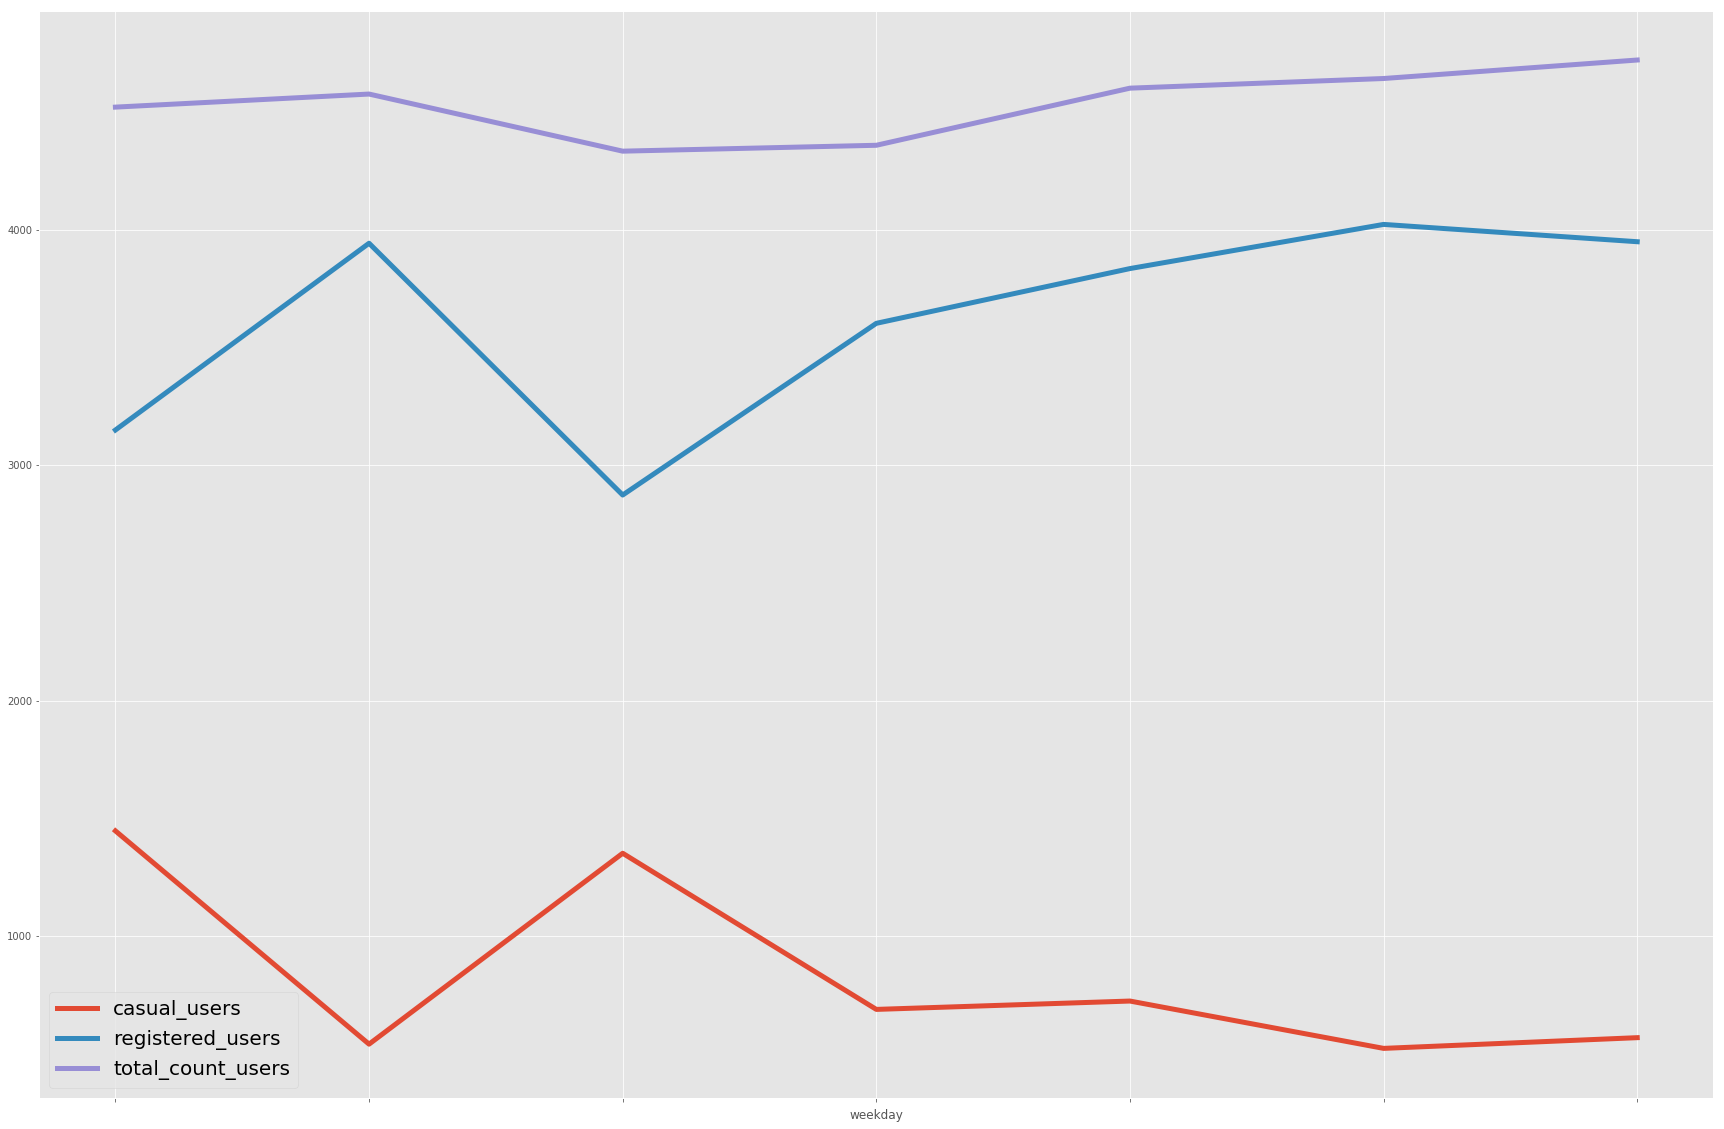

In [51]:
data_day_weekday.plot(x="weekday", y=["casual_users",
                                      "registered_users",
                                      "total_count_users"], kind="line", linewidth = 5)

### Month vs Number of Users

In [31]:
data_day_month = pd.DataFrame(data_day.groupby("month", as_index=False).median())

data_day_month

,month,temperature,temperature_feels_like,humidity,windspeed,casual_users,registered_users,total_count_users
0,April,0.459584,0.453265,0.569584,0.233836,832.5,3395.5,4293.5
1,August,0.707696,0.654039,0.639166,0.166664,1111.0,4116.5,5229.5
2,December,0.313334,0.317223,0.640208,0.165831,292.5,3155.0,3444.0
3,February,0.285833,0.291671,0.537917,0.195683,199.0,1977.0,2402.0
4,January,0.217500,0.232771,0.537663,0.189988,126.5,1657.5,1939.0
5,July,0.748750,0.697291,0.595625,0.164807,1045.0,4005.5,5446.5
6,June,0.690416,0.639219,0.577916,0.171956,968.5,4359.0,5308.5
7,March,0.380344,0.377200,0.580208,0.220463,508.5,2347.0,3216.5
8,May,0.595833,0.566288,0.707292,0.174448,887.0,3883.5,4890.5
9,November,0.359167,0.363625,0.617084,0.176312,449.0,3746.5,4081.0


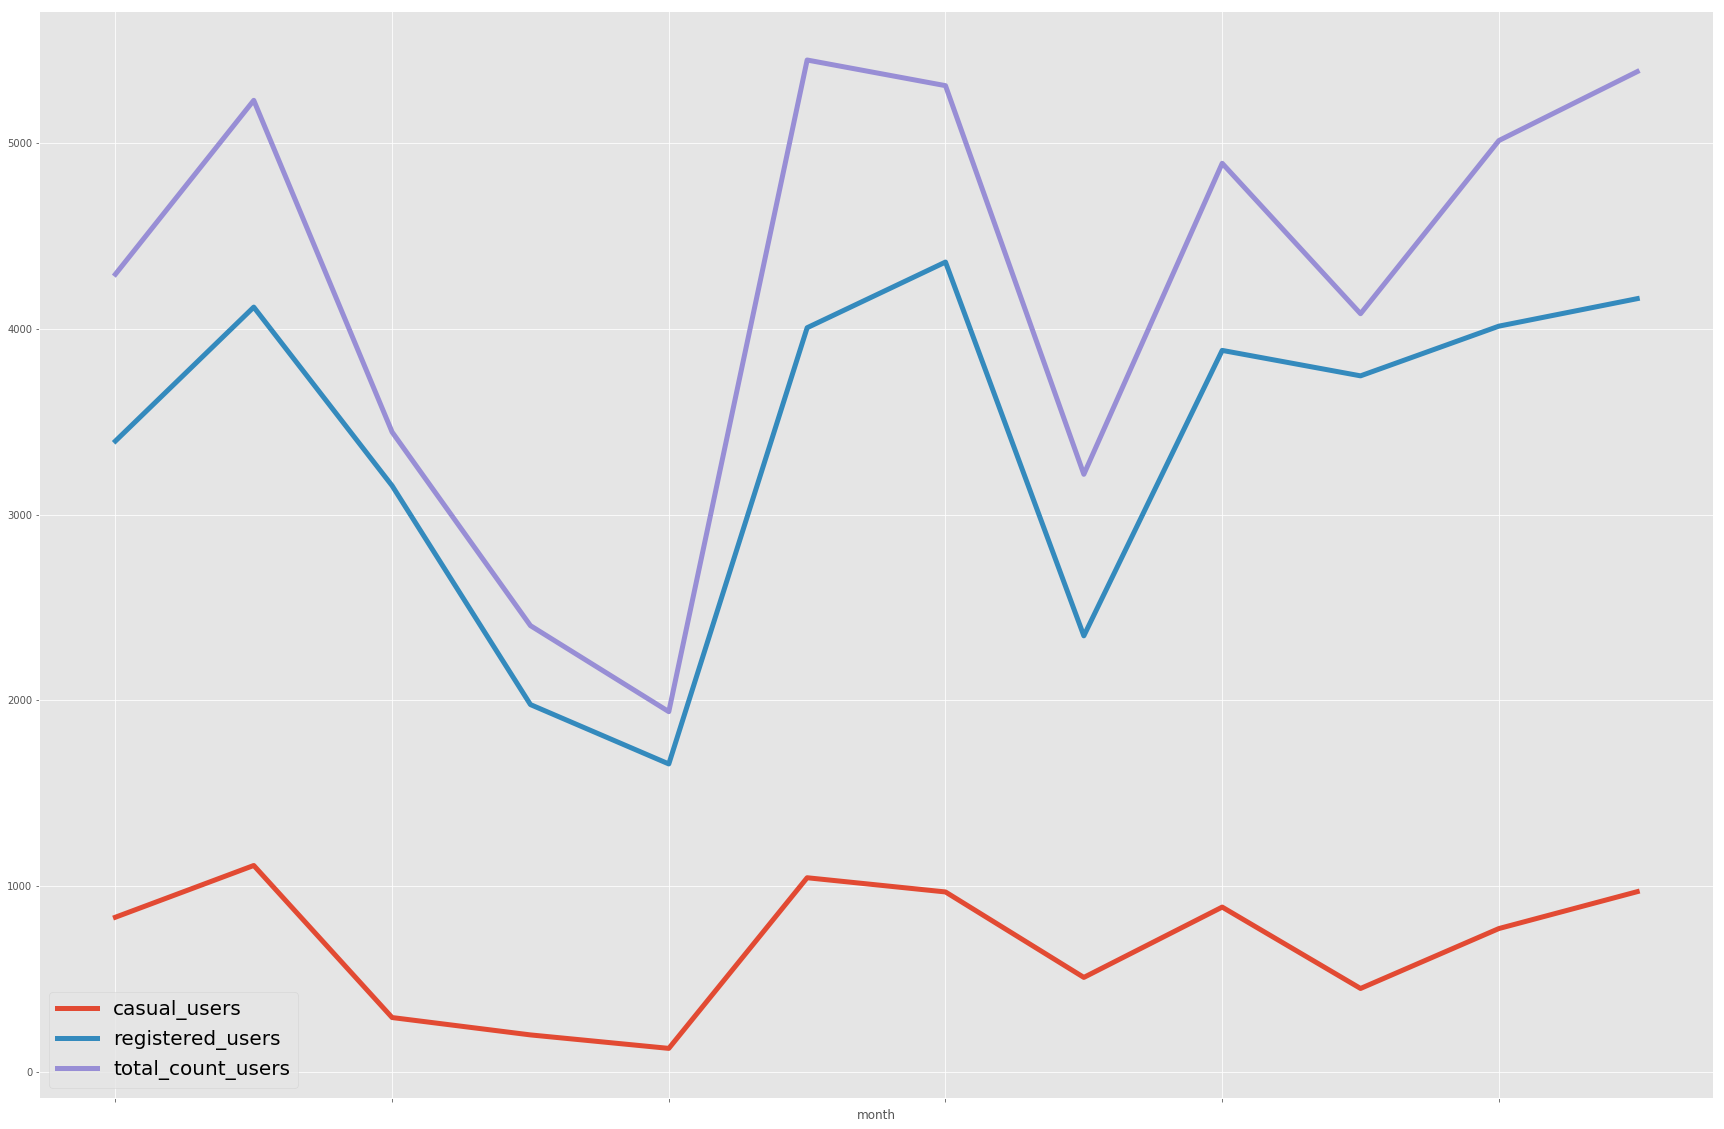

In [50]:
data_day_month.plot(x="month", y=["casual_users",
                                      "registered_users",
                                      "total_count_users"], kind="line", linewidth = 5)

# Dummy Variables - Categorical Features

In [33]:
data_day_dummies = pd.get_dummies(data_day, columns=['season',
                                                     'year',
                                                     'month',
                                                     'holiday',
                                                     'weekday',
                                                     'workingday',
                                                     'weather_type'],drop_first=True)

# Train-Test-Split Data for regression analysis

In [34]:
X = data_day_dummies.drop(["temperature",
                           "casual_users",                 
                           "registered_users",
                           "total_count_users"], axis = 1)

y = data_day_dummies["total_count_users"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Regression Models

## Linear Regression using Scikit-Learn

In [35]:
model = LinearRegression()

model.fit(X_train, y_train)

y_hat = model.predict(X_test)

r2_score(y_test, y_hat)

0.8424160108174163

In [36]:
import scipy
scipy.stats.pearsonr(y_test, y_hat)

(0.9181016625925315, 1.1493332503796976e-74)

## Random Forest Regressor

In [37]:
# Importing the random forest model
from sklearn.ensemble import RandomForestRegressor

# Evaluating model's area under curve ROC
from sklearn.metrics import r2_score, accuracy_score

In [38]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
print(rf.score(X_test, y_test))

y_pred = rf.predict(X_test)

0.8544618499318839


In [40]:
scipy.stats.pearsonr(y_test, y_pred)

(0.9244431210635665, 1.0462259132639211e-77)

In [41]:
feature_importances = pd.DataFrame(rf.feature_importances_ ,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
temperature_feels_like,0.518827
year_2012,0.260152
humidity,0.065444
windspeed,0.033004
season_winter,0.029518
season_spring,0.026376
"weather_type_Mist_Cloudy, Mist",0.008228
weather_type_Light Snow_Light Rain,0.007888
weekday_Saturday,0.006934
workingday_working_day,0.006000


Text(0, 0.5, 'Feature Importance')

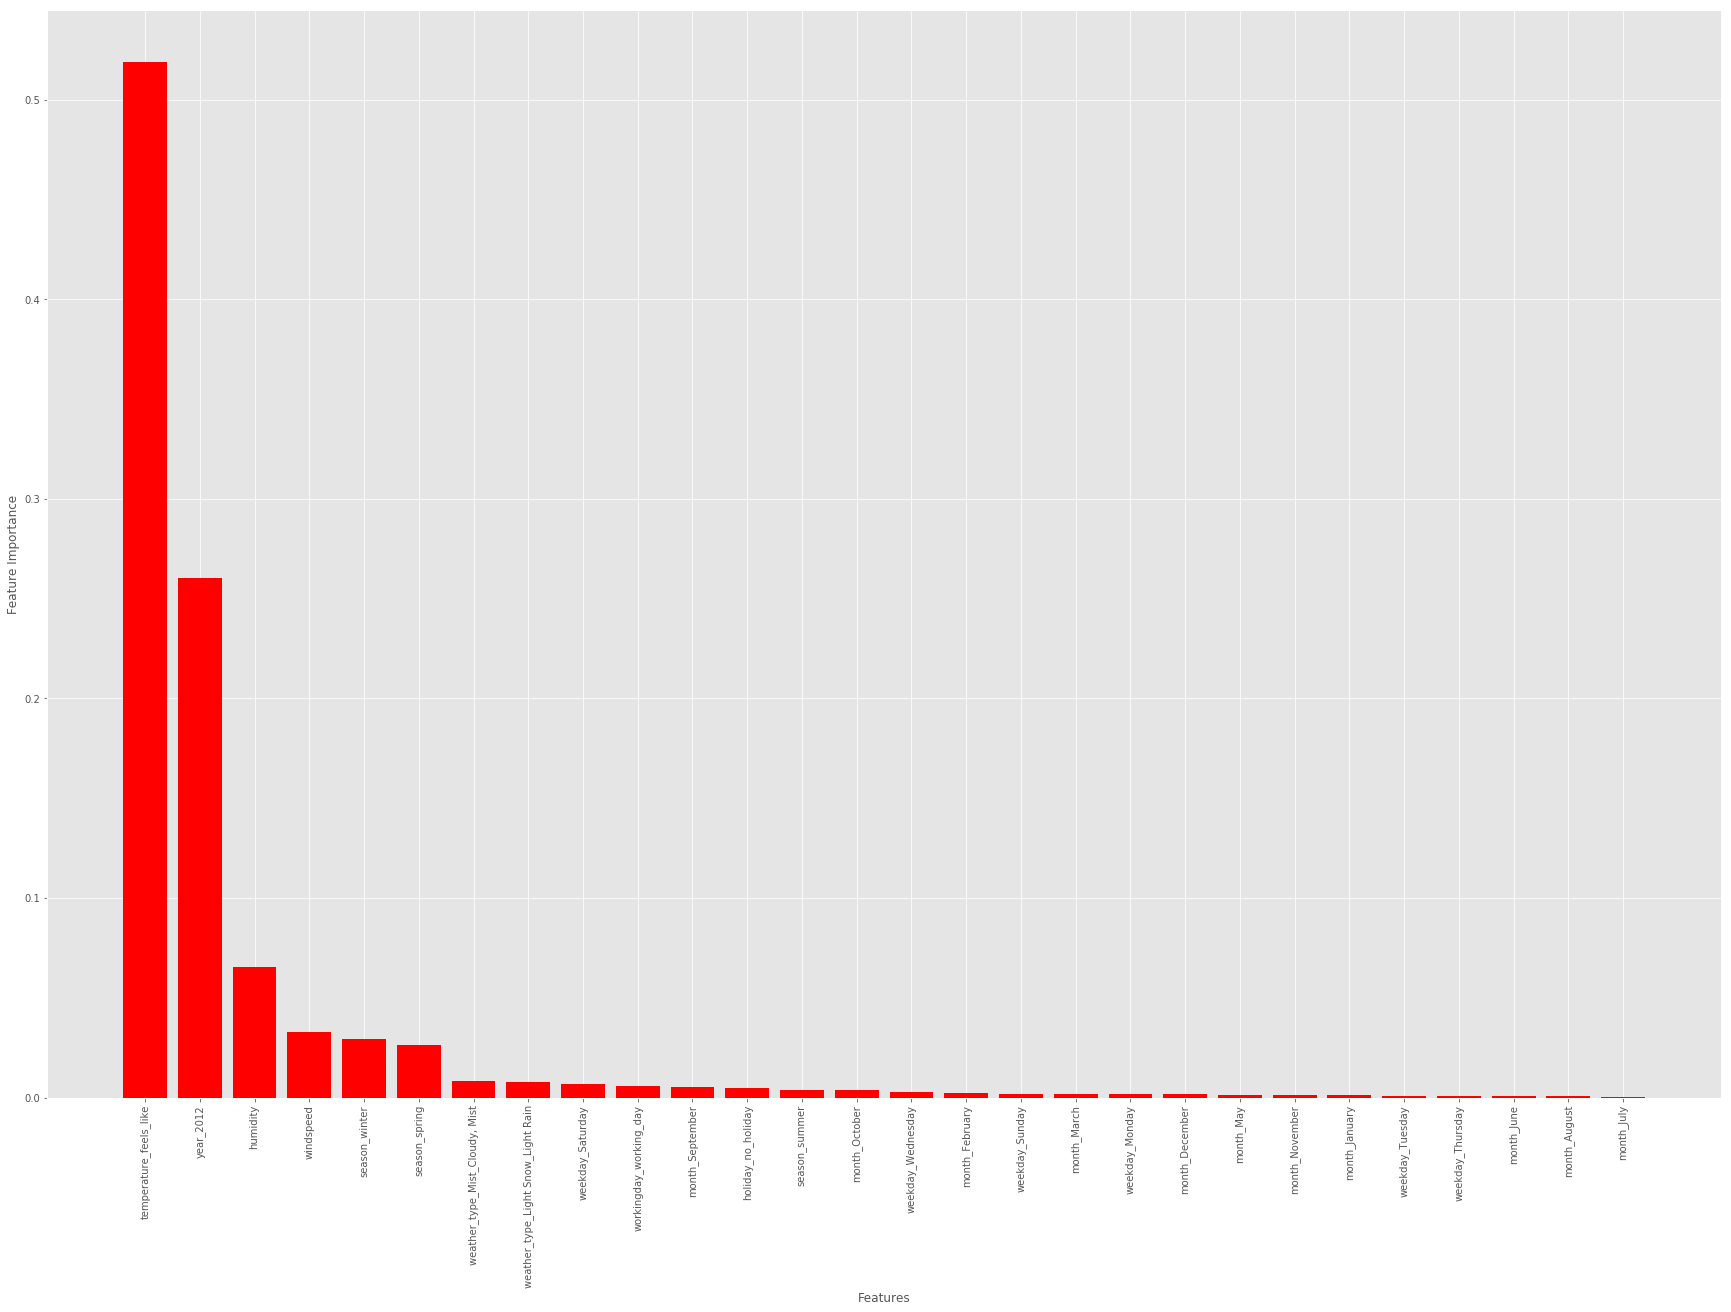

In [42]:
plt.bar(feature_importances.index, feature_importances.importance, color = "red")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.ylabel("Feature Importance") #redraw it as pi-chart and bar chart both

## Deep Neural Nets

In [43]:
# Keras and TensorFlow imports for Deep Learning
import keras
import tensorflow as tf

# Using keras with a Scikit-learn wrapper
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

# for defining the Neural-net
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


In [44]:
def reg_model(learn_rate = 0.01):
    network = keras.models.Sequential()
    layer_1 = Dense(512, input_shape = (X_train.shape[1],), activation="tanh")
    layer_2 = Dense(512, activation="relu")
    layer_3 = Dense(512, activation="relu")
    layer_4 = Dense(1)
    network.add(layer_1)
    network.add(Dropout(0.2))
    network.add(layer_2)
    network.add(Dropout(0.2))
    network.add(layer_3)
    network.add(Dropout(0.2))
    network.add(layer_4)
    network.compile(loss = "mean_squared_error",
                    optimizer = "adam",
                    metrics = ["mse"])
    return network

In [45]:
epochs = 300
batch_size = 32
mlpModel = KerasRegressor(reg_model, epochs=epochs, batch_size=batch_size, verbose=1)
mlpModel.fit(X_train, y_train)
yhat = mlpModel.predict(X_test)
rsquared  = r2_score(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
print(f"Model coefficient of determination, R^2={rsquared}")
print(f"MSE: {mse}")

Epoch 1/300
548/548 [==============================] - 1s 2ms/step - loss: 24377360.5255 - mean_squared_error: 24377360.5255
Epoch 2/300
548/548 [==============================] - 0s 333us/step - loss: 18939684.6715 - mean_squared_error: 18939684.6715
Epoch 3/300
548/548 [==============================] - 0s 335us/step - loss: 5114962.6004 - mean_squared_error: 5114962.6004
Epoch 4/300
548/548 [==============================] - 0s 309us/step - loss: 2873952.6779 - mean_squared_error: 2873952.6779
Epoch 5/300
548/548 [==============================] - 0s 314us/step - loss: 2264051.4045 - mean_squared_error: 2264051.4045
Epoch 6/300
548/548 [==============================] - 0s 328us/step - loss: 1751300.9745 - mean_squared_error: 1751300.9745
Epoch 7/300
548/548 [==============================] - 0s 311us/step - loss: 1454262.2605 - mean_squared_error: 1454262.2605
Epoch 8/300
548/548 [==============================] - 0s 316us/step - loss: 1218283.9443 - mean_squared_error: 1218283.944

Epoch 67/300
548/548 [==============================] - 0s 352us/step - loss: 576575.7874 - mean_squared_error: 576575.7874
Epoch 68/300
548/548 [==============================] - 0s 349us/step - loss: 599569.0744 - mean_squared_error: 599569.0744
Epoch 69/300
548/548 [==============================] - 0s 339us/step - loss: 616634.4122 - mean_squared_error: 616634.4122
Epoch 70/300
548/548 [==============================] - 0s 341us/step - loss: 570704.3148 - mean_squared_error: 570704.3148
Epoch 71/300
548/548 [==============================] - 0s 344us/step - loss: 590846.6414 - mean_squared_error: 590846.6414
Epoch 72/300
548/548 [==============================] - 0s 341us/step - loss: 604168.1460 - mean_squared_error: 604168.1460
Epoch 73/300
548/548 [==============================] - 0s 342us/step - loss: 608833.0976 - mean_squared_error: 608833.0976
Epoch 74/300
548/548 [==============================] - 0s 349us/step - loss: 575151.7055 - mean_squared_error: 575151.7055
Epoch 75

548/548 [==============================] - 0s 364us/step - loss: 625665.1250 - mean_squared_error: 625665.1250
Epoch 133/300
548/548 [==============================] - 0s 356us/step - loss: 571315.2646 - mean_squared_error: 571315.2646
Epoch 134/300
548/548 [==============================] - 0s 348us/step - loss: 584089.6978 - mean_squared_error: 584089.6978
Epoch 135/300
548/548 [==============================] - 0s 350us/step - loss: 525003.1079 - mean_squared_error: 525003.1079
Epoch 136/300
548/548 [==============================] - 0s 350us/step - loss: 542995.4457 - mean_squared_error: 542995.4457
Epoch 137/300
548/548 [==============================] - 0s 351us/step - loss: 521589.7855 - mean_squared_error: 521589.7855
Epoch 138/300
548/548 [==============================] - 0s 345us/step - loss: 524835.2687 - mean_squared_error: 524835.2687
Epoch 139/300
548/548 [==============================] - 0s 341us/step - loss: 537607.1594 - mean_squared_error: 537607.1594
Epoch 140/300


548/548 [==============================] - 0s 363us/step - loss: 514054.7393 - mean_squared_error: 514054.7393
Epoch 198/300
548/548 [==============================] - 0s 358us/step - loss: 503495.5214 - mean_squared_error: 503495.5214
Epoch 199/300
548/548 [==============================] - 0s 354us/step - loss: 517645.3205 - mean_squared_error: 517645.3205
Epoch 200/300
548/548 [==============================] - 0s 360us/step - loss: 535435.6784 - mean_squared_error: 535435.6784
Epoch 201/300
548/548 [==============================] - 0s 362us/step - loss: 501530.6150 - mean_squared_error: 501530.6150
Epoch 202/300
548/548 [==============================] - 0s 356us/step - loss: 510566.2702 - mean_squared_error: 510566.2702
Epoch 203/300
548/548 [==============================] - 0s 358us/step - loss: 490488.6359 - mean_squared_error: 490488.6359
Epoch 204/300
548/548 [==============================] - 0s 361us/step - loss: 529584.2548 - mean_squared_error: 529584.2548
Epoch 205/300


548/548 [==============================] - 0s 366us/step - loss: 492992.2235 - mean_squared_error: 492992.2235
Epoch 263/300
548/548 [==============================] - 0s 352us/step - loss: 494278.3020 - mean_squared_error: 494278.3020
Epoch 264/300
548/548 [==============================] - 0s 357us/step - loss: 503460.8034 - mean_squared_error: 503460.8034
Epoch 265/300
548/548 [==============================] - 0s 360us/step - loss: 511776.4948 - mean_squared_error: 511776.4948
Epoch 266/300
548/548 [==============================] - 0s 350us/step - loss: 486861.3970 - mean_squared_error: 486861.3970
Epoch 267/300
548/548 [==============================] - 0s 353us/step - loss: 472560.3668 - mean_squared_error: 472560.3668
Epoch 268/300
548/548 [==============================] - 0s 358us/step - loss: 492104.8635 - mean_squared_error: 492104.8635
Epoch 269/300
548/548 [==============================] - 0s 361us/step - loss: 464567.3234 - mean_squared_error: 464567.3234
Epoch 270/300


In [46]:
scipy.stats.pearsonr(y_test, yhat)

(0.9248012395466528, 6.918971226236757e-78)